In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as patches
from matplotlib import colormaps as cm
import os
import glob
import gaitFunctions
from gaitFunctions import swingTimingProportions
from gaitFunctions import offsetGaitstyleLabels
from scipy import stats
import seaborn as sns

def meanstdstr(vals):
    return str(np.round(np.mean(vals),2)) + ' ± ' + str(np.round(np.std(vals),2))

In [2]:
# plot colors and parameters
axis_fontsize=11
tick_fontsize=9

# colors for step kinematics
stance_color = '#5656ff'
swing_color = '#e1e813'
duty_color = '#4d4d4d'
ipsi_color = 'tab:red'
contra_color = 'tab:green'

# colors for legs
first_pair_color = '#bc272d' # red
first_pair_color_alt = '#f77276' # salmon
second_pair_color = '#50a9d4' # teal
second_pair_color_alt = '#95bbfc' # sky blue
third_pair_color = '#fa9805' # orange
third_pair_color_alt = '#e9c716' # gold
rear_leg_color = '#703391'# violet
rear_leg_color_alt = '#0000a2' # indigo

# scatter marker size and alpha
marker_size = 10
marker_alpha = 0.7
marker_color = 'k'

In [3]:
# leg relationships and colors
first_pair = ['L1','R1']
second_pair = ['L2','R2']
third_pair = ['L3','R3']
fourth_pair = ['L4','R4']
rear_legs = fourth_pair
lateral_legs = third_pair + second_pair + first_pair
ipsi_offset_legs = third_pair + second_pair
left_laterals = [x[0] for x in [third_pair, second_pair, first_pair]]
right_laterals = [x[1] for x in [third_pair, second_pair, first_pair]]
all_legs = rear_legs + lateral_legs
left_legs = [x[0] for x in [fourth_pair, third_pair, second_pair, first_pair]]
right_legs = [x[1] for x in [fourth_pair, third_pair, second_pair, first_pair]]
single_leg = ['R4']

# dictionaries of inter-leg relationships
ipsi_legs = {'L4':'L3','R4':'R3','L3':'L2','L2':'L1','R3':'R2','R2':'R1'}
contra_legs = {'L4':'R4','R4':'L4','L3':'R3','L2':'R2','R3':'L3','R2':'L2','L1':'R1','R1':'L1'}

# colors
all_leg_color = 'dimgrey'
L2_L1_color =   second_pair_color
L3_L2_color =   third_pair_color
R2_R1_color =   second_pair_color_alt
R3_R2_color =   third_pair_color_alt

In [4]:
# navigate to directory that contains the data
os.chdir('/Users/iwoods/OneDrive - Ithaca College/2024_movement_disorder_paper/analyses_summaries')
xl_files = sorted(glob.glob('*.xlsx'))
excel_file = gaitFunctions.selectOneFromList(xl_files)

# load the step_timing data into a dataframe
step_df = pd.read_excel(excel_file, sheet_name='step_timing', index_col=None)
step_df.head(3)


Choose from this list : 
1: exemplaris_2024-01-10.xlsx
2: exemplaris_2024-01-18.xlsx
3: exemplaris_2024-01-25.xlsx
4: path_summaries.xlsx
5: step_summaries.xlsx

Which ONE would you like? 3

You chose exemplaris_2024-01-25.xlsx



,legID,DownTime,UpTime,stance,swing,gait,duty,midSwingTime,L1_mid_swings,R1_mid_swings,...,average_tardigrade_area,average_tardigrade_length,anterior_offsets,contralateral_offsets,metachronal_lag,clip,treatment,individual,date,uniq_id
0,L1,0.272,1.151,0.879,0.242,1.121,0.7841,1.2720,L1:0.8921,R1:,...,16019.862069,255.118156,NaN,0.667,NaN,iw_11Dec_exemplaris_tardigrade01_000-010,exemplaris,1,11dec,iw_11dec_tardigrade01_exemplaris
1,L1,1.393,2.606,1.213,0.303,1.516,0.8001,2.7575,L1:0.9001,R1:0.3701,...,16147.450000,254.255372,NaN,1.030,NaN,iw_11Dec_exemplaris_tardigrade01_000-010,exemplaris,1,11dec,iw_11dec_tardigrade01_exemplaris
2,L1,2.909,4.090,1.181,0.334,1.515,0.7795,4.2570,L1:0.8898,R1:0.5597,...,16140.948718,257.286118,NaN,0.879,NaN,iw_11Dec_exemplaris_tardigrade01_000-010,exemplaris,1,11dec,iw_11dec_tardigrade01_exemplaris


# offset curves

2423 steps for ipsilateral offsets
1797 steps for contralateral offsets
689 steps for rear offsets


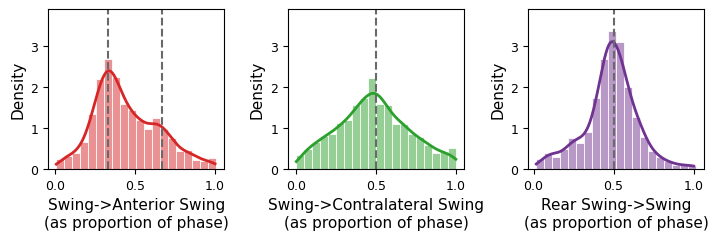

In [5]:
def offsetCurve(ax,leglist,compdict,xlab): # or 'contra' 
    # leglist = ipsi_offset_legs, left_laterals, ['L4']
    # compdict = ipsi_legs, contra_legs, contra_legs

    proportions = []
    speeds = []
    offsets = []
    for leg in leglist:
        offsets, proportions, speeds = swingTimingProportions(offsets, proportions, speeds, 
                                                              step_df, leg, compdict[leg])
    
    if 'anterior' in xlab.lower():
        offset_color = ipsi_color
        desc = 'ipsilateral'
    elif 'rear' in xlab.lower():
        offset_color = rear_leg_color
        desc = 'rear'
    else:
        offset_color = contra_color
        desc = 'contralateral'
    
    ax = sns.histplot(proportions, ax=ax, binwidth=0.05, kde=True, stat='density',line_kws={'linewidth':2},
                      color=offset_color, edgecolor='w', visible=True) # can set to False to hide bars
    print(len(proportions), 'steps for ' + desc + ' offsets')
    ax.set_xlabel(xlab)
    
    if 'anterior' in xlab.lower():
        ax.plot([1/3,1/3],[0,4],'--',color='dimgrey')
        ax.plot([2/3,2/3],[0,4],'--',color='dimgrey')
    else:
        ax.plot([1/2,1/2],[0,4],'--',color='dimgrey')
        
    return ax

f = plt.figure(figsize=(8,2))
ax1=f.add_axes([0.1,0.1,0.22,0.8])
ax2=f.add_axes([0.4,0.1,0.22,0.8])
ax3=f.add_axes([0.7,0.1,0.22,0.8])

ax1=offsetCurve(ax1,ipsi_offset_legs,ipsi_legs,'Swing->Anterior Swing\n(as proportion of phase)')
ax2=offsetCurve(ax2,left_laterals,contra_legs,'Swing->Contralateral Swing\n(as proportion of phase)')
ax3=offsetCurve(ax3,['L4'],contra_legs,'Rear Swing->Swing\n(as proportion of phase)')

# adjust parameters and plot
for ax in [ax1,ax2,ax3]:
    ax.yaxis.label.set_size(axis_fontsize)
    ax.xaxis.label.set_size(axis_fontsize)
    ax.tick_params(axis='both', which='major', labelsize=tick_fontsize) 
    ax.set_ylim([0,3.9])

plt.show()

### ipsilateral offsets for individual legs

L2 : 601 steps
L3 : 604 steps
R2 : 614 steps
R3 : 604 steps


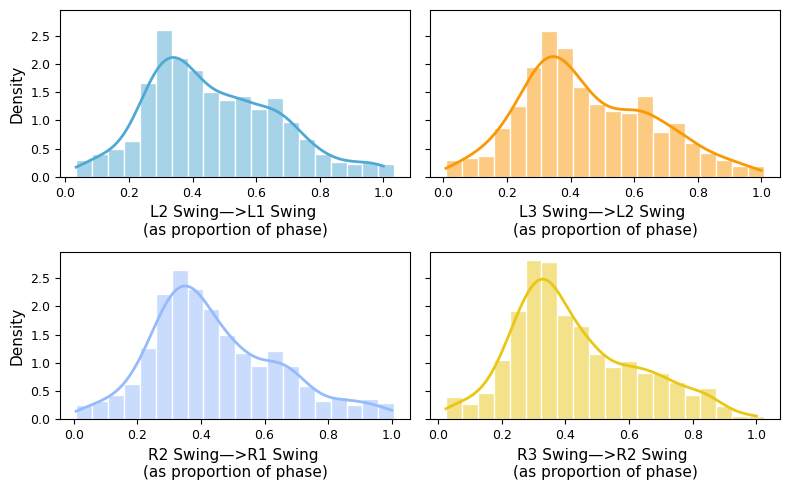

In [6]:
def plotLegOffsets(ax, df, ref_leg, test_leg, barcolor):

    proportions = []
    speeds = []
    offsets = []
    offsets, proportions, speeds = swingTimingProportions(offsets, proportions, speeds, 
                                                          step_df, ref_leg, test_leg)
    
    ax = sns.histplot(proportions, ax=ax, binwidth=0.05, kde=True, stat='density',line_kws={'linewidth':2},
                  color=barcolor, edgecolor='w', visible=True) # can set to false to hide bars
    
#     ax.set_xlabel(' --> '.join(leg_comps[i]) + ' Ipsilateral Offsets', fontsize=axis_fontsize)
    ax.set_xlabel(leg_comps[i][0] + ' Swing—>' + leg_comps[i][1] + ' Swing \n(as proportion of phase)')
    
    print(leg_comps[i][0], ':', len(proportions), 'steps')
    
    return ax

f,axes = plt.subplots(2,2,figsize=(8,5), sharey=True)

leg_comps = [['L2','L1'],['L3','L2'],['R2','R1'],['R3','R2']]
plot_cols = [L2_L1_color,L3_L2_color,R2_R1_color,R3_R2_color]

for i, ax in enumerate(axes.flat):
    
    ax = plotLegOffsets(ax, step_df, leg_comps[i][0], leg_comps[i][1], plot_cols[i])

    # adjust parameters
    ax.xaxis.label.set_size(axis_fontsize)
    ax.yaxis.label.set_size(axis_fontsize)
    ax.tick_params(axis='both', which='major', labelsize=tick_fontsize) 


plt.tight_layout()
plt.show()

### Contralateral offsets for individual legs (Nirody S6B inset)

L1 : 612 steps
L2 : 587 steps
L3 : 598 steps


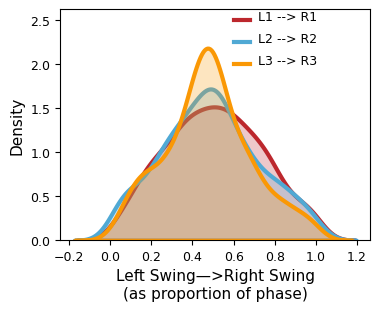

In [7]:
# S6 B inset

def contralateralOffsetIndividualLegs(ax, df, leg_comps, plot_cols, legend_fontsize):

    ypos = 2.5
    
    for i, comp in enumerate(leg_comps):
        proportions = []
        speeds = []
        offsets = []
        offsets, proportions, speeds = swingTimingProportions(offsets, proportions, speeds, df, comp[0], comp[1])
    #     H,X1 = np.histogram(proportions, bins = 200, density = True )
    #     dx = X1[1] - X1[0]
    #     F1 = np.cumsum(H)*dx
    #     ax.plot(X1[1:], F1, linewidth=3, color = plot_cols[i], label=' --> '.join(comp))

#         ax = sns.histplot(proportions, ax=ax, binwidth=0.05,
#                           stat='density',line_kws={'linewidth':3}, kde=True, fill=True,
#                           color=plot_cols[i], edgecolor='w', visible=False) # can set to false to hide bars
        ax = sns.kdeplot(proportions, ax=ax, color=plot_cols[i], linewidth=3, fill=True)

        # klugey legend
        ax.plot([0.6,0.68],[ypos,ypos],color=plot_cols[i],linewidth=3)
        ax.text(0.72,ypos-0.002, ' --> '.join(comp),fontsize=legend_fontsize)
        ypos -= 0.25

        print(comp[0], ':', len(proportions), 'steps')

    ax.set_xlabel('Left Swing—>Right Swing\n(as proportion of phase)')
    return ax

    
f,ax = plt.subplots(1,1,figsize=(4,3))
leg_comps = [['L1','R1'], ['L2','R2'], ['L3','R3']]
plot_cols = [first_pair_color,second_pair_color,third_pair_color]

ax = contralateralOffsetIndividualLegs(ax, step_df, leg_comps, plot_cols, tick_fontsize)

ax.xaxis.label.set_size(axis_fontsize)
ax.yaxis.label.set_size(axis_fontsize)
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize) 
plt.show()

# Combined Figure for individual leg offsets

L2 : 601 steps
L3 : 604 steps
R2 : 614 steps
R3 : 604 steps
L1 : 612 steps
L2 : 587 steps
L3 : 598 steps


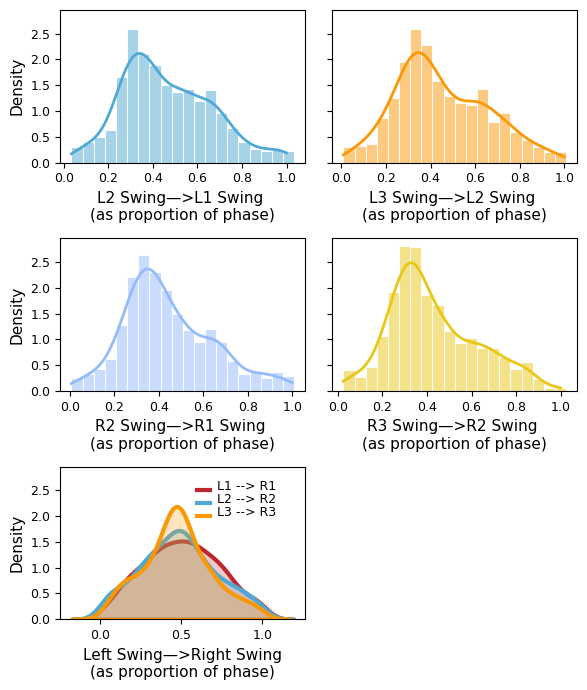

In [8]:
f,axes = plt.subplots(3,2,figsize=(6,7), sharey=True)
axlist = axes.flat

#plotLegOffsets(ax, df, ref_leg, test_leg, barcolor)

leg_comps = [['L2','L1'],['L3','L2'],['R2','R1'],['R3','R2']]
plot_cols = [L2_L1_color,L3_L2_color,R2_R1_color,R3_R2_color]

for i, comp in enumerate(leg_comps):    
    axlist[i] = plotLegOffsets(axlist[i], step_df, comp[0], comp[1], plot_cols[i])

leg_comps = [['L1','R1'], ['L2','R2'], ['L3','R3']]
plot_cols = [first_pair_color,second_pair_color,third_pair_color]
axlist[4] = contralateralOffsetIndividualLegs(axlist[4], step_df, leg_comps, plot_cols, tick_fontsize)

axlist[5].set_axis_off()

for i in np.arange(0,5):
    # adjust parameters
    axlist[i].xaxis.label.set_size(axis_fontsize)
    axlist[i].yaxis.label.set_size(axis_fontsize)
    axlist[i].tick_params(axis='both', which='major', labelsize=tick_fontsize) 

plt.tight_layout()
plt.show()

# Gait styles boxplots

In [9]:
gait_summaries_df = pd.read_excel(excel_file, sheet_name='gait_summaries', index_col=None)
gait_summaries_df.head(3)

,Identifier,treatment,individual,date,Number of frames,% stand (lateral legs),% pentapod (lateral legs),% tetrapod canonical (lateral legs),% tetrapod gallop (lateral legs),% tetrapod other (lateral legs),...,% tripod other (lateral legs),% tripod total (lateral legs,% other (lateral legs),% stand (rear legs),% hop (rear legs),% step (rear legs),Tetrapod Coordination Strength,Tetrapod Bout Speed (bodylength / s),Tripod Coordination Strength,Tripod Bout Speed (bodylength / s)
0,iw_11dec_tardigrade01_exemplaris,exemplaris,tardigrade01,11dec,538,11.152416,50.371747,24.721190,7.992565,5.390335,...,0.000000,0.371747,0.0,13.382900,1.858736,84.758364,0.364328,0.163901,0.058252,0.166542
1,iw_11dec_tardigrade02_exemplaris,exemplaris,tardigrade02,11dec,564,3.014184,31.737589,31.737589,14.716312,5.319149,...,12.234043,13.475177,0.0,19.680851,5.851064,74.468085,0.320263,0.264520,0.190085,0.250181
2,iw_11dec_tardigrade03_exemplaris,exemplaris,tardigrade03,11dec,506,16.600791,44.466403,27.667984,4.743083,4.545455,...,1.581028,1.976285,0.0,31.225296,0.988142,67.786561,0.459024,0.160521,0.100660,0.117125


In [10]:
# print(gait_summaries_df.columns)
columns_to_analyze = [
    '% stand (lateral legs)', 
    '% pentapod (lateral legs)',
    '% tetrapod canonical (lateral legs)',
    '% tetrapod gallop (lateral legs)', 
    '% tetrapod other (lateral legs)',
    '% tetrapod total (lateral legs)', 
    '% tripod canonical (lateral legs)',
    '% tripod other (lateral legs)', 
    '% tripod total (lateral legs',
#     '% other (lateral legs)', 
    '% stand (rear legs)', 
    '% hop (rear legs)',
    '% step (rear legs)', 
    'Tetrapod Coordination Strength',
    'Tetrapod Bout Speed (bodylength / s)',
    'Tripod Coordination Strength',
    'Tripod Bout Speed (bodylength / s)'
]
print(len(columns_to_analyze))

16


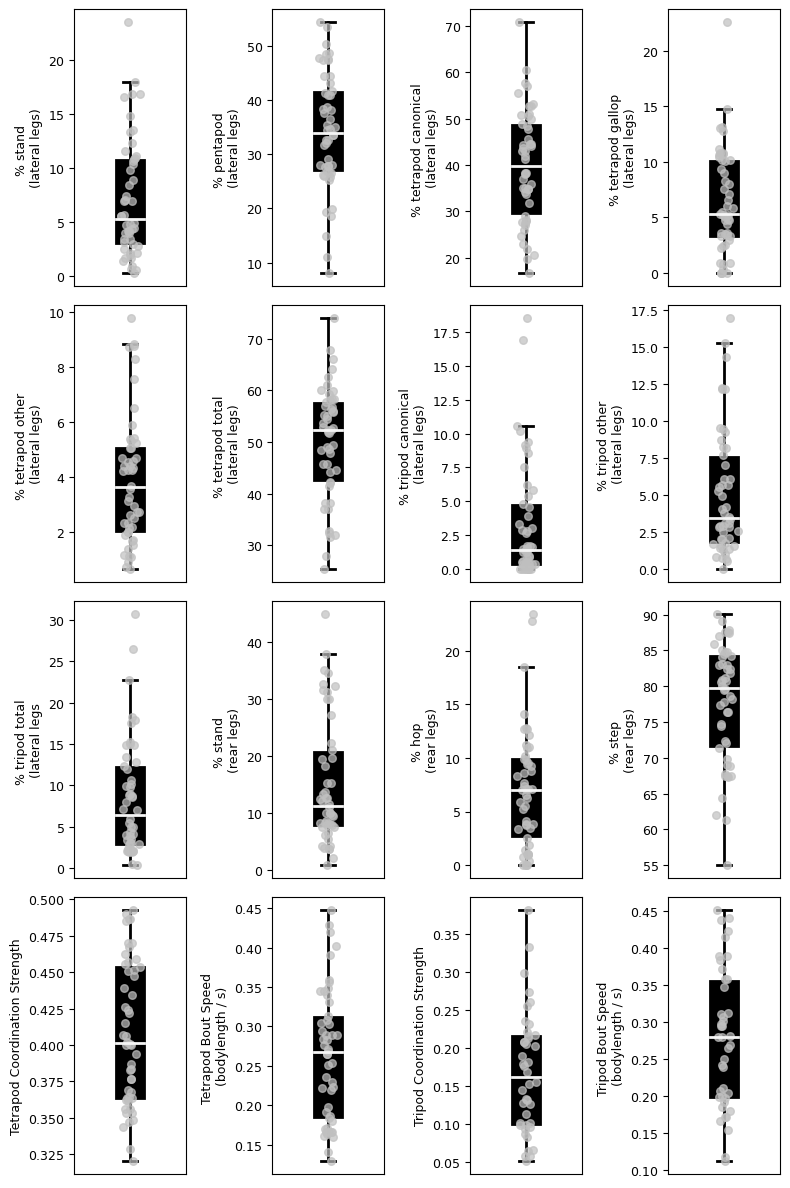

In [11]:
rows,cols = [4,4]
f,axes = plt.subplots(rows,cols,figsize = (8,12))
axes_list = axes.reshape(1,len(columns_to_analyze))[0]
for i, col in enumerate(columns_to_analyze):
    axes_list[i] = gaitFunctions.singleBoxplot(axes_list[i], gait_summaries_df, col)
    axes_list[i].yaxis.label.set_size(tick_fontsize)
    axes_list[i].tick_params(axis='both', which='major', labelsize=tick_fontsize)
    lab = col
    lab = lab.replace('(','\n(')
    axes_list[i].yaxis.label.set_text(lab)
plt.tight_layout()
plt.show()

# arrows and stars plots

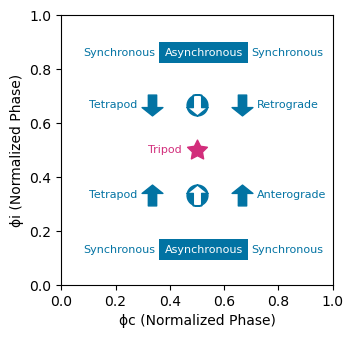

In [11]:
'''
Two functions for plots of contralateral vs. ipsilateral offsets:

    1. Add hazy circles at specified coordinates of ϕc and ϕi
    2. Determine if offsets make a 'canonical' tetrapod or tripod gait
    
'''

def hazyCircle(ax, x, y, rmax, num_radii, linewidth, color_map):
    cmap = cm.get_cmap(color_map)
    crange = np.linspace(0,1,num_radii)
    for i,r in enumerate(np.linspace(0,rmax,num_radii)):
        ec = cmap(1-crange[i])
        circ = patches.Circle((x,y),radius = r, fill=False, 
                      edgecolor=ec, linewidth=linewidth)
        ax.add_patch(circ)
    return ax

def canonicalGait(anterior_offset, opposite_offset):
    
    # do these offsets make a 'canonical' tetrapod or tripod gait?
    anterior_ok = False
    opposite_ok = False
    is_canonical = False
    
    if anterior_offset * 3 == 1 or anterior_offset * 3 == 2 or anterior_offset * 2 == 1:
        anterior_ok = True
    if opposite_offset * 3 == 1 or opposite_offset * 3 == 2 or opposite_offset * 2 == 1:
        opposite_ok = True
        
    if anterior_ok and opposite_ok:
        is_canonical = True
        
    return is_canonical

f,ax = plt.subplots(1,1,figsize=(3.5,3.5))
ax=offsetGaitstyleLabels(ax, True, 8)
plt.show()

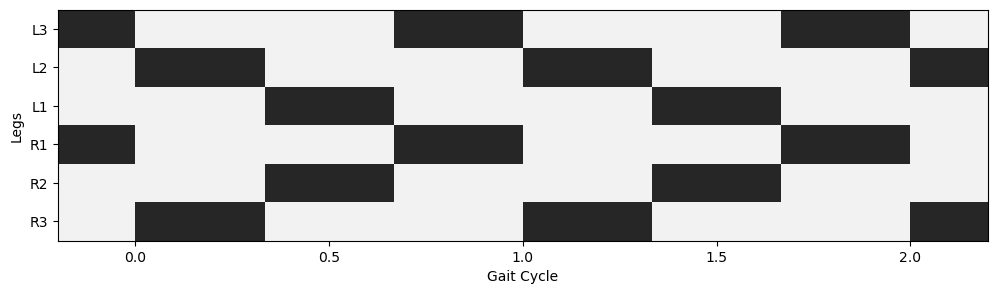

In [12]:
# In GaitFunctions we have a function (plotSimulatedSteps) 
# to plot simulated steps given inputs of duty factor and offsets
num_cycles = 4
num_legs = 6
duty_factor =     2/3 # in fraction of gait cycle
anterior_offset = 1/3 # in fraction of gait cycle
opposite_offset = 1/3 # in fraction of gait cycle

f,ax = plt.subplots(1,1, figsize = (12,3))      
ax, plot_legs, stance_start = gaitFunctions.plotSimulatedSteps(ax, num_legs, num_cycles, 
                                                               duty_factor, anterior_offset, 
                                                               opposite_offset)
ax.set_xlim([-.2, 2.2])
plt.show()

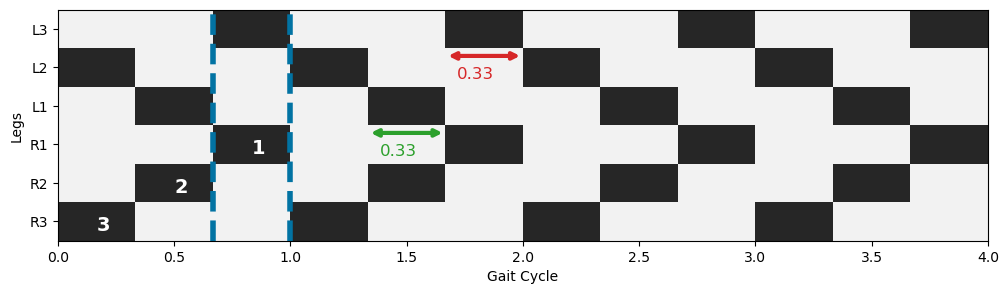

In [13]:
# Function to add annotations about offsets and swing order to a plot of simulated steps
def annotateSimulatedSteps(ax, plot_legs, duty_factor, anterior_offset, opposite_offset, stance_start):

    leg_y = dict(zip(plot_legs,np.arange(1,len(plot_legs) + 1)))
    
    # draw vertical lines surrounding first L3 swing in tripod color or tetrapod color
    vertical_linewidth = 4
    combos, combo_colors = gaitFunctions.get_gait_combo_colors('lateral')
    if 0.4 < anterior_offset < 0.6 and 0.4 < opposite_offset < 0.6:
        gait_color = combo_colors['tripod_canonical']
        gait_style = 'Tripod'
    elif 0.2 < anterior_offset <= 0.4 or 0.6 < anterior_offset <= 0.8:
        gait_color = combo_colors['tetrapod_canonical']
        gait_style = 'Tetrapod'
    else:
        gait_style = 'unknown'
    ax.plot([duty_factor,duty_factor],[1,len(plot_legs)+1],'--', color = gait_color, linewidth = vertical_linewidth)
    ax.plot([1,1],[1,len(plot_legs)+1],'--', color = gait_color, linewidth = vertical_linewidth)

    # draw horizontal lines to measure offsets
    # anterior offset draw from 2nd swing of L3

    offset_fontsize = 12
    offset_ybuff = 0.2
    offsettext_xbuff = 0.05
    offsettext_ybuff = 0.6
    anterior_offset_x = duty_factor + 1
    anterior_offset_y = leg_y['L3'] - offset_ybuff
    ax.annotate(text='', xy=(anterior_offset_x+anterior_offset,anterior_offset_y), 
                 xytext=(anterior_offset_x,anterior_offset_y), 
                 arrowprops={'arrowstyle':'<->', 'lw':3, 'edgecolor':'tab:red'})
    ax.text(anterior_offset_x + offsettext_xbuff, anterior_offset_y-offsettext_ybuff, 
            str(np.round(anterior_offset,2)), color='tab:red', fontsize=offset_fontsize)

    # opposite offset draw from 2nd swing of L1
    L1_stances = np.array([stance_start['L1']])
    opposite_offset_x = np.min(L1_stances[np.where(L1_stances>0)]) + duty_factor
#         opposite_offset_x = anterior_offset_x - anterior_offset
    opposite_offset_y = leg_y['L1'] - offset_ybuff
    ax.annotate(text='', xy=(opposite_offset_x+opposite_offset,opposite_offset_y), 
             xytext=(opposite_offset_x,opposite_offset_y), 
             arrowprops={'arrowstyle':'<->', 'lw':3, 'edgecolor':'tab:green'})
    ax.text(opposite_offset_x + offsettext_xbuff , opposite_offset_y-offsettext_ybuff, 
            str(np.round(opposite_offset,2)), color='tab:green', fontsize=offset_fontsize)

    # set title of plot to gait style
    if gait_style == 'Tetrapod':
        if opposite_offset == 1/2:
            gait_style += ' Asynchronous'
        else:
            gait_style += ' Synchronous'
        if anterior_offset == 1/3:
            gait_style += ' Rear-to-Front'
        else:
            gait_style += ' Front-to-Rear'

    # label step order starting at R3
    ybuff = 0.25
    xbuff = 0.02 * duty_factor
    text_y = leg_y['R3'] + ybuff
    # R3 swing is L3 swing + opposite_offset
    text_x = duty_factor + (1-duty_factor)/2 + opposite_offset 
    if 'Rear-to-Front' in gait_style:
        # plot R3, R2, R1 starting with first R3 swing
        text_x = text_x -1
        ax.text(text_x, text_y, '3', fontsize=14, color='w', fontweight='bold' )
        ax.text(text_x+anterior_offset, text_y+1, '2', fontsize=14, color='w', fontweight='bold' )
        ax.text(text_x+2*anterior_offset, text_y+2, '1', fontsize=14, color='w', fontweight='bold' )
    elif 'Front-to-Rear' in gait_style:    
        # plot R1, R2, R3 starting with first R1 swing
        ax.text(text_x, text_y, '3', fontsize=14, color='w', fontweight='bold' )
        ax.text(text_x-(1-anterior_offset), text_y+1, '2', fontsize=14, color='w', fontweight='bold' )
        ax.text(text_x-2*(1-anterior_offset), text_y+2, '1', fontsize=14, color='w', fontweight='bold' )

#     if gait_style != 'unknown':
#         ax.set_title(gait_style, fontsize=14)
    
    return ax

# A sample . . . 
num_cycles = 4
num_legs = 6
duty_factor =     2/3 # in fraction of gait cycle
anterior_offset = 1/3 # in fraction of gait cycle
opposite_offset = 1/3 # in fraction of gait cycle
f,ax = plt.subplots(1,1, figsize = (12,3))
ax, plot_legs, stance_start = gaitFunctions.plotSimulatedSteps(ax, num_legs, num_cycles, duty_factor, anterior_offset, opposite_offset)
ax = annotateSimulatedSteps(ax, plot_legs, duty_factor, anterior_offset, opposite_offset, stance_start)
ax.set_xlim([0,num_cycles*duty_factor + num_cycles*(1-duty_factor)])
plt.show()

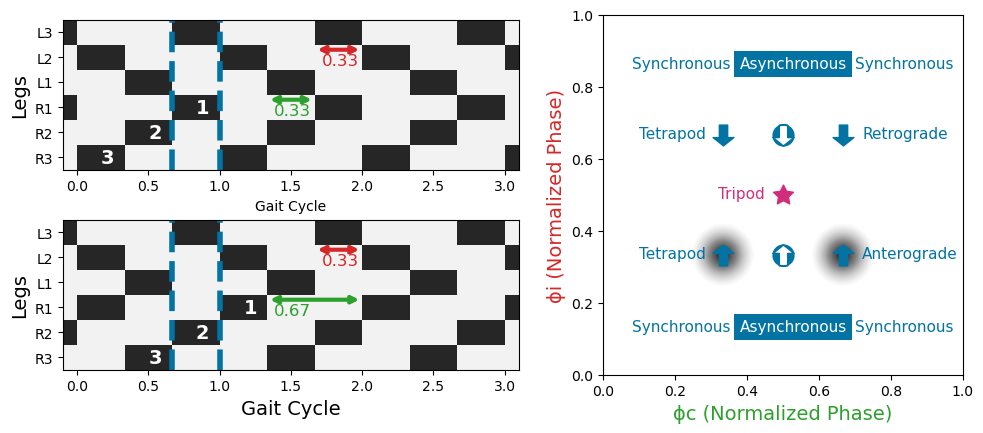

In [14]:
# Exploring specific combinations:
# here = Tetrapod anterograde
# anterior offset is 1/3, opposite offset is 1/3 or 2/3

num_cycles = 4
duty_factor =     2/3 # in fraction of gait cycle
anterior_offset = 1/3 # in fraction of gait cycle
opposite_offset = 1/3 # in fraction of gait cycle

f = plt.figure(figsize = (12,5))
ax1 = f.add_axes([0.1,0.55,0.38,0.30])
ax1, plot_legs, stance_start = gaitFunctions.plotSimulatedSteps(ax1, num_legs, num_cycles, 
                                                                duty_factor, anterior_offset, opposite_offset)
ax1 = annotateSimulatedSteps(ax1, plot_legs, duty_factor, anterior_offset, opposite_offset, stance_start)
ax1.set_xlim([-0.1,3.1])
ax1.yaxis.label.set_size(14)

ax2 = f.add_axes([0.1,0.15,0.38,0.30])
ax2, plot_legs, stance_start = gaitFunctions.plotSimulatedSteps(ax2, num_legs, num_cycles, 
                                                                duty_factor, anterior_offset, opposite_offset+1/3)
ax2 = annotateSimulatedSteps(ax2, plot_legs, duty_factor, anterior_offset, opposite_offset+1/3, stance_start)
ax2.set_xlim([-0.1,3.1])
ax2.set_xlabel('Gait Cycle')
ax2.xaxis.label.set_size(14)
ax2.yaxis.label.set_size(14)

ax3 = f.add_axes([0.55, 0.1, 0.3, 0.8])
ax3 = offsetGaitstyleLabels(ax3, True, 11)
ax3.set_aspect('equal')
ax3.xaxis.label.set_size(14)
ax3.yaxis.label.set_size(14)
ax3.xaxis.label.set_color(contra_color)
ax3.yaxis.label.set_color(ipsi_color)

ax3 = hazyCircle(ax3, opposite_offset, anterior_offset, 0.09, 30, 2, 'Greys')
ax3 = hazyCircle(ax3, opposite_offset+1/3, anterior_offset, 0.09, 30, 2, 'Greys')

plt.show()

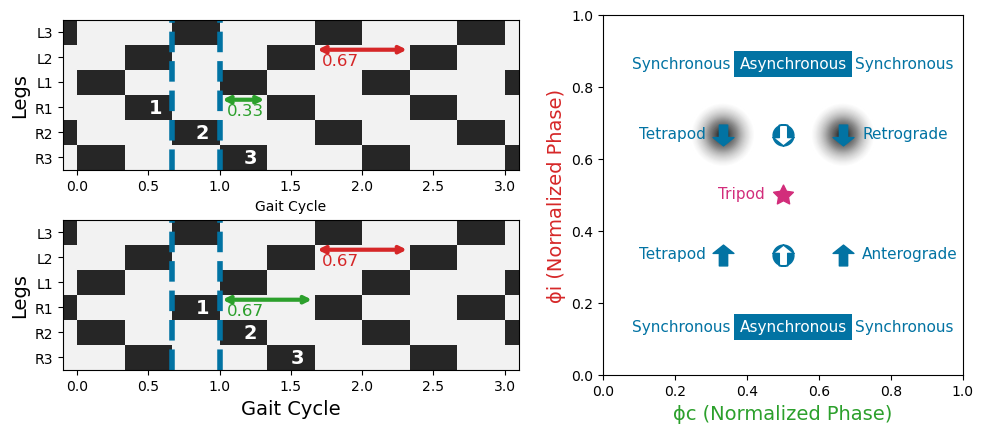

In [15]:
# Exploring specific combinations:
# here = Tetrapod retrograde
# anterior offset is 2/3, opposite offset is 1/3 or 2/3

num_cycles = 4
duty_factor =     2/3 # in fraction of gait cycle
anterior_offset = 2/3 # in fraction of gait cycle
opposite_offset = 1/3 # in fraction of gait cycle

f = plt.figure(figsize = (12,5))
ax1 = f.add_axes([0.1,0.55,0.38,0.30])
ax1, plot_legs, stance_start = gaitFunctions.plotSimulatedSteps(ax1, num_legs, num_cycles, 
                                                                duty_factor, anterior_offset, opposite_offset)
ax1 = annotateSimulatedSteps(ax1, plot_legs, duty_factor, anterior_offset, opposite_offset, stance_start)
ax1.set_xlim([-0.1,3.1])
ax1.yaxis.label.set_size(14)

ax2 = f.add_axes([0.1,0.15,0.38,0.30])
ax2, plot_legs, stance_start = gaitFunctions.plotSimulatedSteps(ax2, num_legs, num_cycles, 
                                                                duty_factor, anterior_offset, opposite_offset+1/3)
ax2 = annotateSimulatedSteps(ax2, plot_legs, duty_factor, anterior_offset, opposite_offset+1/3, stance_start)
ax2.set_xlim([-0.1,3.1])
ax2.set_xlabel('Gait Cycle')
ax2.xaxis.label.set_size(14)
ax2.yaxis.label.set_size(14)

ax3 = f.add_axes([0.55, 0.1, 0.3, 0.8])
ax3 = offsetGaitstyleLabels(ax3, True, 11)
ax3.set_aspect('equal')
ax3.xaxis.label.set_size(14)
ax3.yaxis.label.set_size(14)
ax3.xaxis.label.set_color(contra_color)
ax3.yaxis.label.set_color(ipsi_color)

ax3 = hazyCircle(ax3, opposite_offset, anterior_offset, 0.09, 30, 2, 'Greys')
ax3 = hazyCircle(ax3, opposite_offset+1/3, anterior_offset, 0.09, 30, 2, 'Greys')

plt.show()

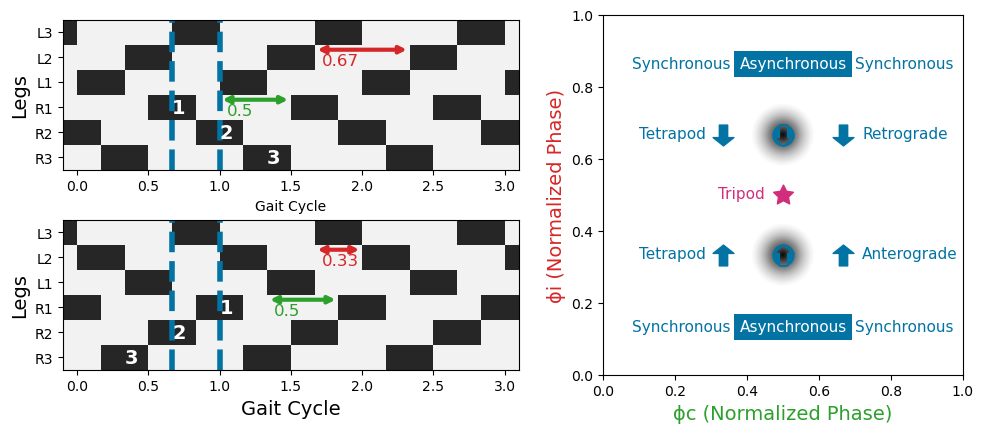

In [16]:
# Exploring specific combinations:
# here = Tetrapod 'asynchronous'
# anterior offset is 1/3 (anterograde), or 2/3 (retrograde)
# opposite offset 1/2 (asynchronous)

num_cycles = 4
duty_factor =     2/3 # in fraction of gait cycle
anterior_offset = 2/3 # in fraction of gait cycle
opposite_offset = 1/2 # in fraction of gait cycle

f = plt.figure(figsize = (12,5))
ax1 = f.add_axes([0.1,0.55,0.38,0.30])
ax1, plot_legs, stance_start = gaitFunctions.plotSimulatedSteps(ax1, num_legs, num_cycles, 
                                                                duty_factor, anterior_offset, opposite_offset)
ax1 = annotateSimulatedSteps(ax1, plot_legs, duty_factor, anterior_offset, opposite_offset, stance_start)
ax1.set_xlim([-0.1,3.1])
ax1.yaxis.label.set_size(14)

ax2 = f.add_axes([0.1,0.15,0.38,0.30])
ax2, plot_legs, stance_start = gaitFunctions.plotSimulatedSteps(ax2, num_legs, num_cycles, 
                                                                duty_factor, anterior_offset-1/3, opposite_offset)
ax2 = annotateSimulatedSteps(ax2, plot_legs, duty_factor, anterior_offset-1/3, opposite_offset, stance_start)
ax2.set_xlim([-0.1,3.1])
ax2.set_xlabel('Gait Cycle')
ax2.xaxis.label.set_size(14)
ax2.yaxis.label.set_size(14)

ax3 = f.add_axes([0.55, 0.1, 0.3, 0.8])
ax3 = offsetGaitstyleLabels(ax3, True, 11)
ax3.set_aspect('equal')
ax3.xaxis.label.set_size(14)
ax3.yaxis.label.set_size(14)
ax3.xaxis.label.set_color(contra_color)
ax3.yaxis.label.set_color(ipsi_color)

ax3 = hazyCircle(ax3, opposite_offset, anterior_offset, 0.09, 30, 2, 'Greys')
ax3 = hazyCircle(ax3, opposite_offset, anterior_offset-1/3, 0.09, 30, 2, 'Greys')

plt.show()

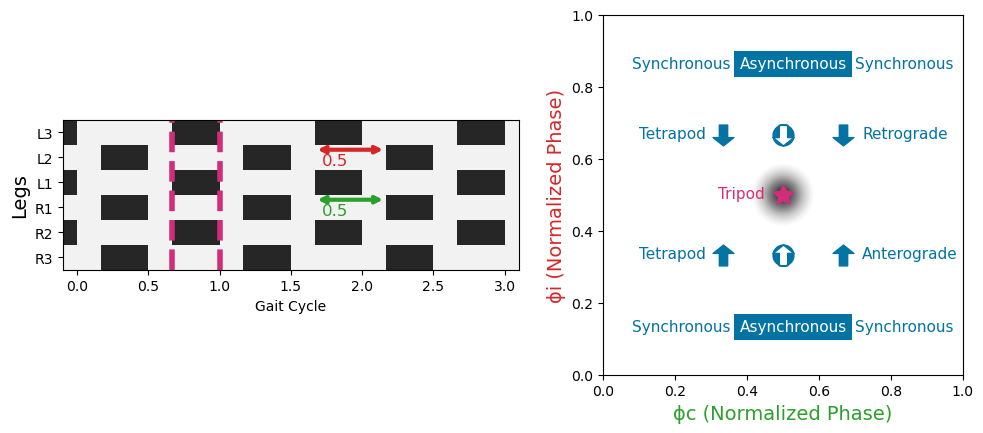

In [17]:
# Exploring specific combinations:
# here = Tripod
# anterior offset is 1/2; opposite offset 1/2

num_cycles = 4
duty_factor =     2/3 # in fraction of gait cycle
anterior_offset = 1/2 # in fraction of gait cycle
opposite_offset = 1/2 # in fraction of gait cycle

f = plt.figure(figsize = (12,5))
ax1 = f.add_axes([0.1,0.35,0.38,0.30])
ax1, plot_legs, stance_start = gaitFunctions.plotSimulatedSteps(ax1, num_legs, num_cycles, 
                                                                duty_factor, anterior_offset, opposite_offset)
ax1 = annotateSimulatedSteps(ax1, plot_legs, duty_factor, anterior_offset, opposite_offset, stance_start)
ax1.set_xlim([-0.1,3.1])
ax1.yaxis.label.set_size(14)

ax3 = f.add_axes([0.55, 0.1, 0.3, 0.8])
ax3 = offsetGaitstyleLabels(ax3, True, 11)
ax3.set_aspect('equal')
ax3.xaxis.label.set_size(14)
ax3.yaxis.label.set_size(14)
ax3.xaxis.label.set_color(contra_color)
ax3.yaxis.label.set_color(ipsi_color)

ax3 = hazyCircle(ax3, opposite_offset, anterior_offset, 0.09, 30, 2, 'Greys')

plt.show()

# Contralateral vs. ipsilateral phases
## ϕc (Normalized Phase) vs. ϕi (Normalized Phase)
### Nirody Figure 4D

Strides:  2023


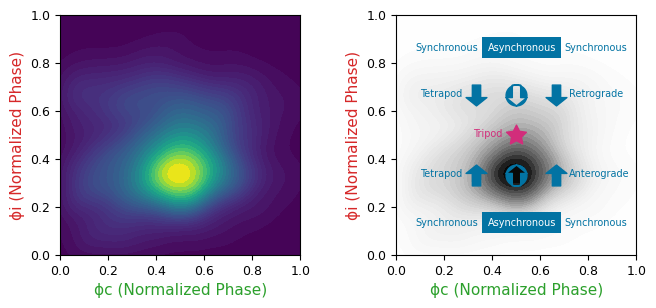

In [18]:
ipsi_swing_offset_proportions = []
contra_swing_offset_proportions = []
speeds=[]

# code modified from swingTimingProportions function above
individuals = np.sort(np.unique(step_df['uniq_id'].values))
for ref_leg in ipsi_offset_legs:
    for individual in individuals:
        individual_data = step_df[step_df['uniq_id']==individual]
        ref_leg_swings = individual_data[individual_data['legID'] == ref_leg]['UpTime'].values
        anterior_leg_swings = individual_data[individual_data['legID'] == ipsi_legs[ref_leg]]['UpTime'].values
        opposite_leg_swings = individual_data[individual_data['legID'] == contra_legs[ref_leg]]['UpTime'].values
        
        ref_leg_speeds = individual_data[individual_data['legID'] == ref_leg]['speed_during_step'].values
        ref_leg_bodylengths = individual_data[individual_data['legID'] == ref_leg]['average_tardigrade_length'].values
        
        for i, ref_swing in enumerate(ref_leg_swings[:-1]):
            next_ref_swing = ref_leg_swings[i+1]
            next_ant_idx = np.where(anterior_leg_swings>ref_swing)[0]
            next_opp_idx = np.where(opposite_leg_swings>ref_swing)[0]
            
            # add speed
            speed_during_step = ref_leg_speeds[i]
            length_during_step = ref_leg_bodylengths[i]
            
            if len(next_ant_idx) > 0 and len(next_opp_idx) > 0:
                next_ant_swing = anterior_leg_swings[next_ant_idx[0]]
                next_opp_swing = opposite_leg_swings[next_opp_idx[0]]
                
                ref_cycle = next_ref_swing-ref_swing
                
                ant_swing_offset = next_ant_swing-ref_swing
                opp_swing_offset = next_opp_swing-ref_swing
                
                ant_swing_phase_proportion = ant_swing_offset / ref_cycle
                opp_swing_phase_proportion = opp_swing_offset / ref_cycle
                
                if ant_swing_phase_proportion <= ref_cycle and opp_swing_phase_proportion < ref_cycle:
                    ipsi_swing_offset_proportions.append(ant_swing_phase_proportion) 
                    contra_swing_offset_proportions.append(opp_swing_phase_proportion)
                    speeds.append(speed_during_step/length_during_step)

ipsi_phase = np.array(ipsi_swing_offset_proportions)
cont_phase = np.array(contra_swing_offset_proportions)
print('Strides: ', len(ipsi_phase))

f = plt.figure(figsize=(8,3))
ax1 = f.add_axes([0.1,0.1,0.38,0.8])
ax2 = f.add_axes([0.52,0.1,0.38,0.8], sharex=ax1, sharey=ax1)

ax1 = sns.kdeplot(ax=ax1, x=cont_phase, y=ipsi_phase, fill=True, cmap='viridis', thresh=0, levels=30)
ax2 = sns.kdeplot(ax=ax2, x=cont_phase, y=ipsi_phase, fill=True, cmap='Greys', thresh=0, levels=30) # Greys or binary

for ax in [ax1,ax2]:
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.set_xlabel('ϕc (Normalized Phase)', fontsize=axis_fontsize, color=contra_color)
    ax.set_ylabel('ϕi (Normalized Phase)', fontsize=axis_fontsize, color=ipsi_color)
    ax.set_aspect('equal')
    ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)

ax2=offsetGaitstyleLabels(ax2, True, 7) # False for no text
plt.show()

# Gait Style Proportion Plots

Number of individuals here:  50


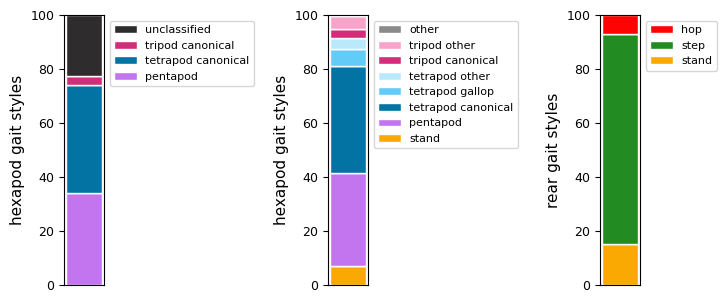

Values to match Nirody paper ... tripod: 3.3%; tetrapod: 39.8%; pentapod: 34.2%; unclassified: 22.7%


Nirody paper vals =               tripod: 3%,  tetrapod: 31%,   pentapod: 10%


In [19]:
''' 
Nirody figure 1D ... 
Percentages in canonical hexapod gait categories
They only report pentapod, canonical tripod, canonical tetrapod, and 'unclassified'

We can reproduce this ...
And we can also get a bit more granular
For example, for tetrapod we can report: tetrapod canonical, tetrapod gallop, tetrapod other
... and for tripod we can report: tripod canonical, tripod other

So, we will report these numbers (Nirody version and our more granular version)
Also, make plots (Nirody plot with their colors, our plot with our colors)

Can also report what the rear legs are doingd

'''
hexapod_combos, hexapod_color_dict = gaitFunctions.get_gait_combo_colors('hexapod')
bipod_combos, bipod_color_dict = gaitFunctions.get_gait_combo_colors('bipod')

# load gait data from gait_styles sheet
gait_df = pd.read_excel(excel_file, sheet_name='gait_summaries', index_col=None)
num_individuals = len(gait_df['% pentapod (lateral legs)'].values)
print('Number of individuals here: ', num_individuals)

# Nirody reported values for hexapod gait (and hex colors)
pentapod = np.mean(gait_df['% pentapod (lateral legs)'].values) # color = #d22d7b
tetrapod_canonical = np.mean(gait_df['% tetrapod canonical (lateral legs)'].values) #009bdd
tripod_canonical = np.mean(gait_df['% tripod canonical (lateral legs)'].values) #5d257e
unclassified = 100 - (pentapod + tetrapod_canonical + tripod_canonical) #181818

# Rest of the values for hexapod gait (and adjacent colors)
stand = np.mean(gait_df['% stand (lateral legs)'].values) #bf1717
tetrapod_gallop = np.mean(gait_df['% tetrapod gallop (lateral legs)'].values) #a4ddf5
tetrapod_other = np.mean(gait_df['% tetrapod other (lateral legs)'].values) #caecfa
tripod_other = np.mean(gait_df['% tripod other (lateral legs)'].values) #c292de
other = np.mean(gait_df['% other (lateral legs)'].values) #8a8a8a

# Values for rear legs
rear_stand = np.mean(gait_df['% stand (rear legs)'].values)
rear_step = np.mean(gait_df['% step (rear legs)'].values)
rear_hop = np.mean(gait_df['% hop (rear legs)'].values)

# set up figure
f = plt.figure(figsize=(8,3))
hexapod_ylab = 'hexapod gait styles'

# Nirody hexapod categories
ax1 = f.add_axes([0.05,0.05,0.05,0.9])
groups = [['exemplaris']]
n_categories = ['pentapod','tetrapod canonical','tripod canonical','unclassified']
n_proportions = [[pentapod, tetrapod_canonical, tripod_canonical, unclassified]]
n_plot_colors = [hexapod_color_dict[x.replace(' ','_')] for x in n_categories]
ax1 = gaitFunctions.percentagesPlotWithLegend(ax1, groups, n_categories, n_proportions, 
                                              n_plot_colors, hexapod_ylab)

# All hexapod categories
ax2 = f.add_axes([0.38,0.05,0.05,0.9])
a_categories = ['stand','pentapod','tetrapod canonical','tetrapod gallop','tetrapod other',
              'tripod canonical','tripod other','other']
a_proportions = [[stand, pentapod, tetrapod_canonical, tetrapod_gallop, tetrapod_other,
                tripod_canonical, tripod_other, other]]
a_plot_colors = [hexapod_color_dict[x.replace(' ','_')] for x in a_categories]
ax2 = gaitFunctions.percentagesPlotWithLegend(ax2, groups, a_categories, a_proportions, 
                                              a_plot_colors, hexapod_ylab)

# Rear categories
ax3 = f.add_axes([0.72,0.05,0.05,0.9]) 
r_categories = ['stand','step','hop']
r_proportions = [[rear_stand, rear_step, rear_hop]]
r_plot_colors = [bipod_color_dict[x] for x in r_categories]
ax3 = gaitFunctions.percentagesPlotWithLegend(ax3, groups, r_categories, r_proportions, 
                                              r_plot_colors, 'rear gait styles')

summary = 'Values to match Nirody paper ... '
summary += ('tripod: ' + str(np.round(tripod_canonical,1)) + '%; ')
summary += ('tetrapod: ' + str(np.round(tetrapod_canonical,1)) + '%; ')
summary += ('pentapod: ' + str(np.round(pentapod,1)) + '%; ')
summary += ('unclassified: ' + str(np.round(unclassified,1)) + '%')

for ax in [ax1,ax2,ax3]:
    ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
    ax.yaxis.label.set_size(axis_fontsize)

plt.show()
print(summary)
print('\n')
print('Nirody paper vals =               tripod: 3%,  tetrapod: 31%,   pentapod: 10%')

# coordination strength vs. speed or % tetrapod or tripod

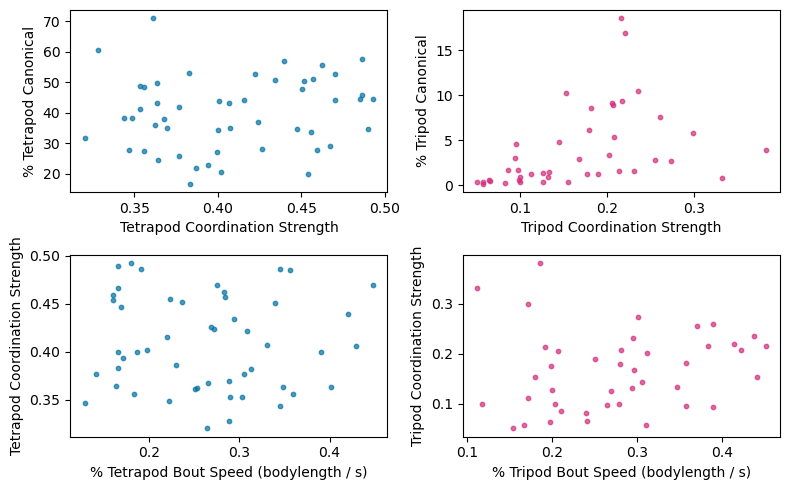

In [20]:
# ... coordination strength vs. speed? but want to save speed for next figure?
id_tetrapod = dict(zip(gait_df['Identifier'].values, 
                       gait_df['% tetrapod canonical (lateral legs)'].values))
id_tripod = dict(zip(gait_df['Identifier'].values, 
                       gait_df['% tripod canonical (lateral legs)'].values))
# ... coordination strength vs. % tetrapod or tripod ... let's see how those look
combos, combo_colors = gaitFunctions.get_gait_combo_colors('lateral')
tetra_color = combo_colors['tetrapod_canonical']
tripod_color = combo_colors['tripod_canonical']
f,[[ax1,ax2],[ax3,ax4]] = plt.subplots(2,2,figsize=(8,5))
ax1.scatter(gait_df['Tetrapod Coordination Strength'].values,
           gait_df['% tetrapod canonical (lateral legs)'].values,s=marker_size,
            alpha=marker_alpha,c=tetra_color)
ax1.set_ylabel('% Tetrapod Canonical')
ax1.set_xlabel('Tetrapod Coordination Strength')
ax2.scatter(gait_df['Tripod Coordination Strength'].values,
           gait_df['% tripod canonical (lateral legs)'].values,s=marker_size,
            alpha=marker_alpha,c=tripod_color)
ax2.set_ylabel('% Tripod Canonical')
ax2.set_xlabel('Tripod Coordination Strength')

ax3.scatter(gait_df['Tetrapod Bout Speed (bodylength / s)'].values,
           gait_df['Tetrapod Coordination Strength'].values,s=marker_size,
            alpha=marker_alpha,c=tetra_color)
ax3.set_xlabel('% Tetrapod Bout Speed (bodylength / s)')
ax3.set_ylabel('Tetrapod Coordination Strength')
ax4.scatter(gait_df['Tripod Bout Speed (bodylength / s)'].values,
           gait_df['Tripod Coordination Strength'].values,s=marker_size,
            alpha=marker_alpha,c=tripod_color)
ax4.set_xlabel('% Tripod Bout Speed (bodylength / s)')
ax4.set_ylabel('Tripod Coordination Strength')

plt.tight_layout()
plt.show()

Tetrapod ρ = -0.05 p = 0.72
Tripod   ρ = 0.26 p = 0.1


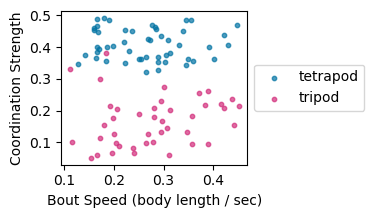

In [21]:
# Bout Speed vs. Coordination Strength on same axis
f,a = plt.subplots(1,1,figsize=(3,2))

tet_x = gait_df['Tetrapod Bout Speed (bodylength / s)'].values
tet_y = gait_df['Tetrapod Coordination Strength'].values
tri_x = gait_df['Tripod Bout Speed (bodylength / s)'].values
tri_y = gait_df['Tripod Coordination Strength'].values
tri_x = tri_x[~np.isnan(tri_x)]
tri_y = tri_y[~np.isnan(tri_y)]

a.scatter(tet_x,tet_y,s=marker_size,alpha=marker_alpha,c=tetra_color,label='tetrapod')
a.scatter(tri_x,tri_y,s=marker_size,alpha=marker_alpha,c=tripod_color,label='tripod')
a.set_xlabel('Bout Speed (body length / sec)')
a.set_ylabel('Coordination Strength')

# Shrink current axis by 20%
box = a.get_position()
a.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
a.legend(loc='center left', bbox_to_anchor=(1, 0.5))

tet_r,tet_p = stats.spearmanr(tet_x,tet_y)
tri_r,tri_p = stats.spearmanr(tri_x,tri_y)
print('Tetrapod ρ =', np.round(tet_r,2), 'p =', np.round(tet_p,2))
print('Tripod   ρ =', np.round(tri_r,2), 'p =', np.round(tri_p,2))

plt.show()

# Combined figure 
## with offset curves, ϕc x ϕi, and gait proportions

2423 steps for ipsilateral offsets
1797 steps for contralateral offsets
689 steps for rear offsets
Tetrapod ρ = -0.05 p = 0.72
Tripod   ρ = 0.26 p = 0.1


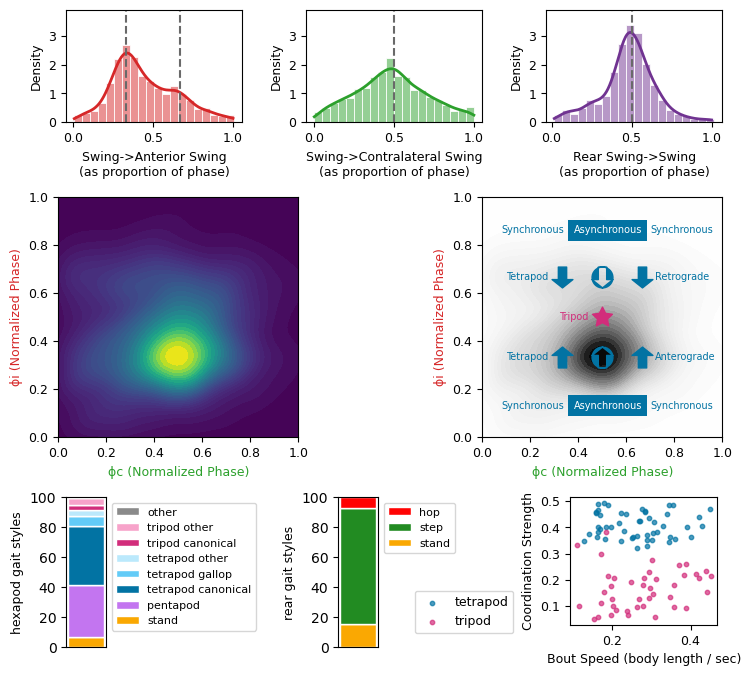

In [22]:
f = plt.figure(figsize = (8,7.5))

# offsets
ipsi_ax = f.add_axes(  [0.1, 0.75,0.22,0.15])
contra_ax = f.add_axes([0.4, 0.75,0.22,0.15])
rear_ax = f.add_axes(  [0.7, 0.75,0.22,0.15])
ipsi_ax=offsetCurve(ipsi_ax,ipsi_offset_legs,ipsi_legs,'Swing->Anterior Swing\n(as proportion of phase)')
contra_ax=offsetCurve(contra_ax,left_laterals,contra_legs,'Swing->Contralateral Swing\n(as proportion of phase)')
rear_ax=offsetCurve(rear_ax,['L4'],contra_legs,'Rear Swing->Swing\n(as proportion of phase)')

# ϕc x ϕi heatmaps
heatmap_ax = f.add_axes ([0.08,  0.33,0.32,0.32])
arrowmap_ax = f.add_axes([0.61 , 0.33,0.32,0.32], sharex=heatmap_ax, sharey=heatmap_ax)
heatmap_ax = sns.kdeplot(ax=heatmap_ax, x=cont_phase, y=ipsi_phase, fill=True, cmap='viridis', thresh=0, levels=30)
arrowmap_ax = sns.kdeplot(ax=arrowmap_ax, x=cont_phase, y=ipsi_phase, fill=True, cmap='Greys', thresh=0, levels=30) # Greys or binary
arrowmap_ax=offsetGaitstyleLabels(arrowmap_ax, True, 7) # False for no text

# gait style proportions
hexgait_ax = f.add_axes( [0.1, 0.05, 0.05,  0.2])
reargait_ax = f.add_axes([0.44, 0.05, 0.05, 0.2])
hexgait_ax = gaitFunctions.percentagesPlotWithLegend(hexgait_ax, groups, a_categories, 
                                                 a_proportions, a_plot_colors, 
                                                 'hexapod gait styles')
reargait_ax = gaitFunctions.percentagesPlotWithLegend(reargait_ax, groups, r_categories, 
                                                      r_proportions, r_plot_colors,
                                                      'rear gait styles')

cs_ax = f.add_axes([0.73, 0.08, 0.23, 0.17])
cs_ax.scatter(tet_x,tet_y,s=marker_size,alpha=marker_alpha,c=tetra_color,label='tetrapod')
cs_ax.scatter(tri_x,tri_y,s=marker_size,alpha=marker_alpha,c=tripod_color,label='tripod')
cs_ax.set_xlabel('Bout Speed (body length / sec)', fontsize=tick_fontsize)
cs_ax.set_ylabel('Coordination Strength', fontsize=tick_fontsize)
cs_ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
# Shrink current axis by 20%
box = cs_ax.get_position()
cs_ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
cs_ax.legend(loc='center left', bbox_to_anchor=(-1.1, 0.1), fontsize=tick_fontsize)

tet_r,tet_p = stats.spearmanr(tet_x,tet_y)
tri_r,tri_p = stats.spearmanr(tri_x,tri_y)
print('Tetrapod ρ =', np.round(tet_r,2), 'p =', np.round(tet_p,2))
print('Tripod   ρ =', np.round(tri_r,2), 'p =', np.round(tri_p,2))

# adjust parameters and plot
for ax in [ipsi_ax,contra_ax,rear_ax]:
    ax.yaxis.label.set_size(tick_fontsize)
    ax.xaxis.label.set_size(tick_fontsize)
    ax.tick_params(axis='both', which='major', labelsize=tick_fontsize) 
    ax.set_ylim([0,3.9])
    
for ax in [heatmap_ax,arrowmap_ax]:
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.set_xlabel('ϕc (Normalized Phase)', fontsize=tick_fontsize, color=contra_color)
    ax.set_ylabel('ϕi (Normalized Phase)', fontsize=tick_fontsize, color=ipsi_color)
    ax.set_aspect('equal')
    ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
    
for ax in [hexgait_ax, reargait_ax]:
    ax.yaxis.label.set_size(tick_fontsize)
    

# Partitioning Speed

In [23]:
# functions for partitioning speed
def getValuesWithinBoundary(vec,boundary):
    above_min = vec[np.where(vec>=boundary[0])]
    return above_min[np.where(above_min<=boundary[1])]

def getGaitProportionsInSpeedPartition(speed_partition, category_lists):
    
    # get total number of observations in this partition
    all_speeds = []
    for speed_vals in category_lists:
        all_speeds.extend(getValuesWithinBoundary(speed_vals, speed_partition))
    total_observations = len(all_speeds)

    # for each list of speed values, get the percentage of total that are within this partition
    percents_within_partition = []
    for speed_vals in category_lists:
        speed_vals = np.array(speed_vals)
        within_boundary = getValuesWithinBoundary(speed_vals, speed_partition)
        percents_within_partition.append(len(within_boundary) * 100 / total_observations)
        
    return percents_within_partition

def speedPartitionPlot(ax, speed_boundaries, category_lists, category_names, color_dict):
    
    for i in np.arange(len(speed_boundaries)-1):
        this_partition = [speed_boundaries[i],speed_boundaries[i+1]]

        percent_within_partition = getGaitProportionsInSpeedPartition(this_partition, category_lists)

        bottom = 0
        for j,catname in enumerate(category_names):
            ax.bar(i,percent_within_partition[j],color=color_dict[catname.replace(' ','_')],bottom=bottom)
            bottom += percent_within_partition[j]

    ax.set_ylabel('Percent')
    ax.set_xticks([0,1,2],['Low','Medium','High'])
    ax.set_xlabel(speed_col)
    
    return ax

def gaitDensityPlot(ax, categories, gaitspeed_df, speed_col, include_unclassified):
    # which leg sets to look at?
    if 'pentapod' in categories:
        gait_col = 'gaits_lateral'
        legset = 'hexapod'
    else:
        gait_col = 'gaits_rear'
        legset = 'bipod'

    # set up plot colors
    combos, color_dict = gaitFunctions.get_gait_combo_colors(legset)
    
    category_names = [x.replace('_',' ') for x in categories]
    category_lists = []

    # get speed data for each category
    for i, category in enumerate(categories):
        category_lists.append(gaitspeed_df[gaitspeed_df[gait_col]==category][speed_col].values)
    if include_unclassified:
        category_lists.append(gaitspeed_df[~gaitspeed_df[gait_col].isin(categories)][speed_col].values)
        category_names.append('unclassified')
    # print(category_names)

    for i, catname in enumerate(category_names):
        ax = sns.histplot(category_lists[i], stat='probability', binwidth=0.005, ax=ax, kde=True,
                          element='step', fill=False, visible=False, color=color_dict[catname.replace(' ','_')],
                         legend=True, label=catname)
        
    return ax, category_lists, category_names, color_dict

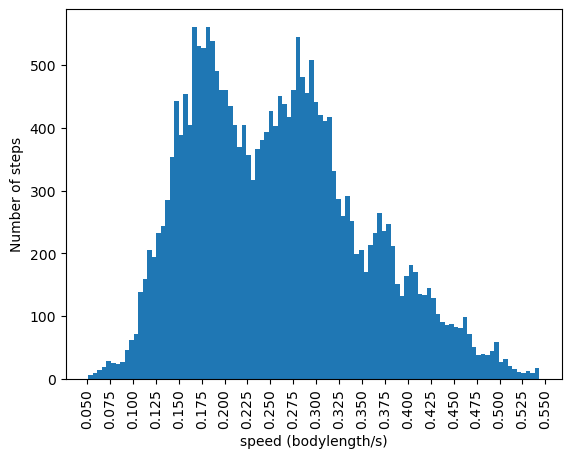

In [24]:
'''
How to partition the speed categories into slow, medium, fast?
First, see if there are any boundaries evident in the speed data
'''

# load the gait_speeds data into a dataframe
# 'cruising' does not matter here because we only measure steps during cruising
gaitspeed_df = pd.read_excel(excel_file, sheet_name='gait_speeds', index_col=None)
speed_col = 'speed (bodylength/s)' # 'speed (bodylength/s)' or 'speed (mm/s)' 
# print(np.unique(gaitspeed_df['gaits_lateral'].values)) # just to see what we have
# print(gaitspeed_df.columns) # just to see what is there

import matplotlib.ticker as ticker
tick_spacing = 0.025
fig, ax = plt.subplots(1,1)
ax.hist(gaitspeed_df[speed_col].values, bins=100)
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax.tick_params(axis='x', rotation=90)
ax.set_ylabel('Number of steps')
ax.set_xlabel(speed_col)
plt.show()

'''
looks like maybe different bins ... 
but I worry that these could be from different days or batches?
'''

# partition speeds into three groups: low, medium, high
speed_boundaries = [0,0.23,0.352,1]

# Speed vs. Ipsilateral Offsets
Maybe those 'shoulders' of ipsilateral offsets at 0.66 depend on speed?<br>
<br>
Partition speed using boundaries suggested in data
<br> = speed_boundaries = [0,0.23,0.352,1]

2423 2423


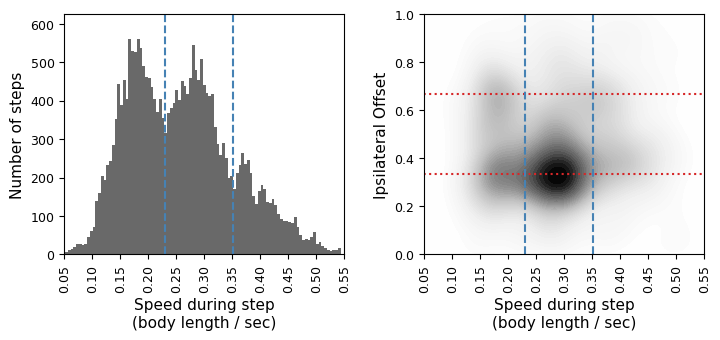

In [25]:
f = plt.figure(figsize=(8,3))
ax1 = f.add_axes([0.1,0.1,0.35,0.8])
ax2 = f.add_axes([0.55,0.1,0.35,0.8], sharex=ax1)

import matplotlib.ticker as ticker
tick_spacing = 0.05

### SPEED HISTOGRAM
# load the gait_speeds data into a dataframe
# 'cruising' does not matter here because we only measure steps during cruising
gaitspeed_df = pd.read_excel(excel_file, sheet_name='gait_speeds', index_col=None)
speed_col = 'speed (bodylength/s)' # 'speed (bodylength/s)' or 'speed (mm/s)' 

ax1.hist(gaitspeed_df[speed_col].values, bins=100, color='dimgrey')
ax1.set_ylabel('Number of steps')

### Speed vs. Ispsilateral offsets
ipsi_proportions = []
ipsi_speeds = []
ipsi_offsets = []

for leg in ipsi_offset_legs:
    ipsi_offsets, ipsi_proportions, ipsi_speeds = swingTimingProportions(ipsi_offsets, ipsi_proportions, 
                                                                         ipsi_speeds, step_df, leg, 
                                                                         ipsi_legs[leg])

print(len(ipsi_proportions), len(ipsi_speeds))

ax2 = sns.kdeplot(ax=ax2, x=ipsi_speeds, y=ipsi_proportions, fill=True, cmap='Greys', thresh=0, levels=50)
ax2.set_ylabel('Ipsilateral Offset', fontsize=14)
ax2.plot([0,1],[1/3,1/3],':',color=ipsi_color)
ax2.plot([0,1],[2/3,2/3],':',color=ipsi_color)
ax2.set_ylim([0,1])

for ax in [ax1,ax2]:
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
    ax.tick_params(axis='x', rotation=90)
    ax.xaxis.label.set_size(axis_fontsize)
    ax.yaxis.label.set_size(axis_fontsize)
    ax.set_xlabel('Speed during step\n(body length / sec)', fontsize=axis_fontsize)
    # ax.xaxis.label.set_text('hihihihi') # cool

# partition speeds into three groups: low, medium, high
speed_boundaries = [0,0.23,0.352,1]

for i in [1,2]:
    ax1.plot([speed_boundaries[i],speed_boundaries[i]],[0,625],'--',color='steelblue')
    ax2.plot([speed_boundaries[i],speed_boundaries[i]],[0,1],'--',color='steelblue')

ax1.set_ylim([0,625])
ax1.set_xlim([0.05,0.55])
    
plt.show()

2349 2349


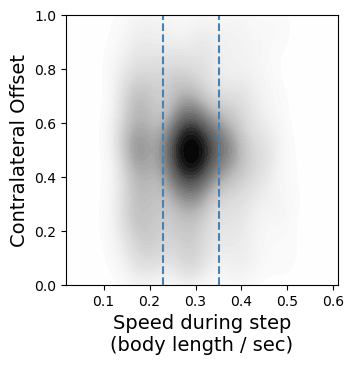

In [26]:
contra_proportions = []
contra_speeds = []
contra_offsets = []

for leg in ipsi_offset_legs:
    contra_offsets, contra_proportions, contra_speeds = swingTimingProportions(contra_offsets, contra_proportions, 
                                                                               contra_speeds, step_df, leg, 
                                                                               contra_legs[leg])

print(len(contra_proportions), len(contra_speeds))

fig,ax2 = plt.subplots(1,1,figsize=(3.5,3.5))
ax2 = sns.kdeplot(ax=ax2, x=contra_speeds, y=contra_proportions, fill=True, cmap='Greys', thresh=0, levels=50)

ax2.set_xlabel('Speed during step\n(body length / sec)', fontsize=14)
ax2.set_ylabel('Contralateral Offset', fontsize=14)
ax2.tick_params(axis='both', which='major', labelsize=10)
ax2.set_ylim([0,1])

for i in [1,2]:
    ax2.plot([speed_boundaries[i],speed_boundaries[i]],[0,1],'--',color='steelblue')

# ax2.set_aspect('equal')
plt.show()

# Partitioned speeds: arrows and stars and gaits

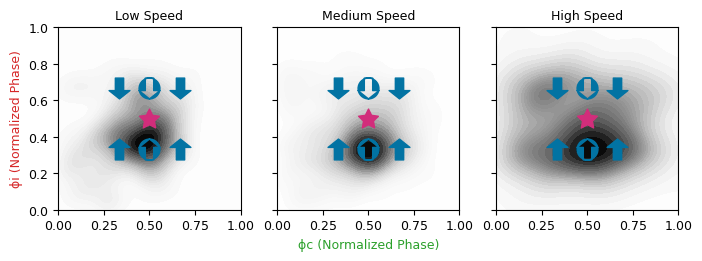

In [27]:
# speed_boundaries = [0,0.225,0.35,1] # before last dataset
speed_boundaries = [0,0.23,0.352,1]

fast_contra = []
fast_ipsi = []
medium_contra = []
medium_ipsi = []
slow_contra = []
slow_ipsi = []

f,[ax1,ax2,ax3] = plt.subplots(1,3,figsize=(8,3),sharey=True)
for i, speed in enumerate(speeds):
    if speed_boundaries[0] < speed <= speed_boundaries[1]:
        fast_contra.append(contra_swing_offset_proportions[i])
        fast_ipsi.append(ipsi_swing_offset_proportions[i])
    elif speed_boundaries[1] < speed <= speed_boundaries[2]:
        medium_contra.append(contra_swing_offset_proportions[i])
        medium_ipsi.append(ipsi_swing_offset_proportions[i])
    else:
        slow_contra.append(contra_swing_offset_proportions[i])
        slow_ipsi.append(ipsi_swing_offset_proportions[i])

cmap = 'Greys' # Greys or binary

ax1 = sns.kdeplot(ax=ax1, x=slow_contra, y=slow_ipsi, fill=True, cmap=cmap, thresh=0, levels=25) 
ax1.set_title('Low Speed', fontsize=tick_fontsize)

ax2 = sns.kdeplot(ax=ax2, x=medium_contra, y=medium_ipsi, fill=True, cmap=cmap, thresh=0, levels=25) 
ax2.set_title('Medium Speed', fontsize=tick_fontsize)

ax3 = sns.kdeplot(ax=ax3, x=fast_contra, y=fast_ipsi, fill=True, cmap=cmap, thresh=0, levels=25) 
ax3.set_title('High Speed', fontsize=tick_fontsize)

for ax in [ax1,ax2,ax3]:
    ax=offsetGaitstyleLabels(ax, False)
#     ax.set_xlim([0.05,0.95])
#     ax.set_ylim([0.05,0.95]) 
#     ax.set_xlabel('ϕc (Normalized Phase)', fontsize=tick_fontsize, color=contra_color)
    ax.xaxis.label.set_text('') # cool
    ax.set_ylabel('ϕi (Normalized Phase)', fontsize=tick_fontsize, color=ipsi_color)
    ax.set_aspect('equal')
    ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)

ax2.set_xlabel('ϕc (Normalized Phase)', fontsize=tick_fontsize, color=contra_color)
plt.show()

# Speed and Gait Style Proportions

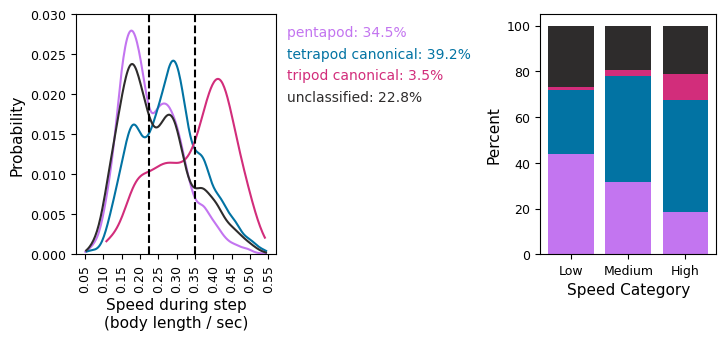

In [28]:
'''
VERSION = 4 gait categories: unclassified, pentapod, tetrapod, tripod

% in each gait are slightly different here compared to kinematics overview notebook
In kinematics overview, I report average value across all individuals
In this analysis, I report average value across all video frames 
    (some individuals have more frames than others)
'''
# partition speeds into three groups: low, medium, high
speed_boundaries = [0,0.225,0.35,1]

# set up categories and values to plot
categories = ['pentapod','tetrapod_canonical','tripod_canonical']
# include unclassified?
include_unclassified = True

# set up figure
f = plt.figure(figsize=(8,3))
ax1 = f.add_axes([0.1,0.1,0.25,0.8])
axLeg = f.add_axes([0.33,0.1,0.2,0.8])
ax2 = f.add_axes([0.68,0.1,0.22,0.8])

# get LEFT axis
ax1, category_lists, category_names, color_dict = gaitDensityPlot(ax1, categories, gaitspeed_df, speed_col, include_unclassified)

ax1.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax1.tick_params(axis='both', which='major', labelsize=tick_fontsize)
ax1.tick_params(axis='x', rotation=90)
ax1.yaxis.label.set_size(axis_fontsize)
ax1.set_xlabel('Speed during step\n(body length / sec)', fontsize=axis_fontsize)

'''
RIGHT = % in each gait in speed categories low, medium, high
'''
# all_speeds = []
# for speed_vals in category_lists:
#     all_speeds.extend(speed_vals)
# plot distribution of different speeds?
# ax2 = sns.histplot(all_speeds, binwidth = 0.01, ax=ax2)

ax2 = speedPartitionPlot(ax2, speed_boundaries, category_lists, category_names, color_dict)
ax2.xaxis.label.set_text('Speed Category')
ax2.yaxis.label.set_size(axis_fontsize)
ax2.xaxis.label.set_size(axis_fontsize)

# fake legend
legend_maxy = 5
legend_yincrement = 0.5
legend_x = 2
# how many are in each gait category
percents_in_category = [np.round(len(x) * 100 / np.sum([len(x) for x in category_lists]),1) for x in category_lists]
for i, catname in enumerate(category_names):
    axLeg.text(legend_x, legend_maxy-(i*legend_yincrement), 
            catname + ': ' + str(percents_in_category[i]) + '%', 
            color=color_dict[catname.replace(' ','_')])
axLeg.set_axis_off()
axLeg.set_xlim([1.5,4.5])
axLeg.set_ylim([0,5.5])

max_line = 0.03
for i in [1,2]:
    ax1.plot([speed_boundaries[i],speed_boundaries[i]],[0,max_line],'--k')

ax2.tick_params(axis='both', which='major', labelsize=tick_fontsize)
    
ax1.set_ylim([0,max_line])
plt.show()

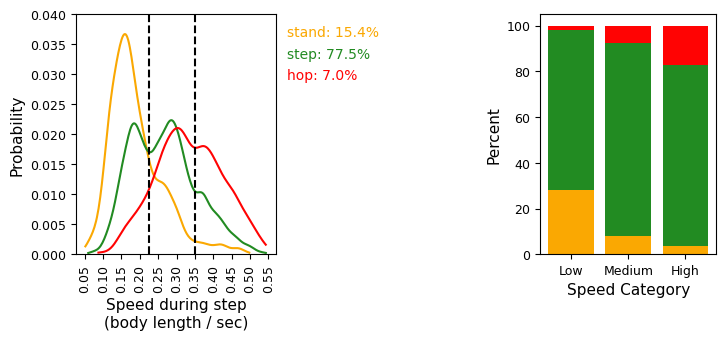

In [29]:
'''
rear legs
'''
# partition speeds into three groups: low, medium, high
speed_boundaries = [0,0.225,0.35,1]

# set up categories and values to plot
rear_categories = ['stand','step','hop']
# include unclassified?
rear_include_unclassified = False

# set up figure
f = plt.figure(figsize=(8,3))
ax1 = f.add_axes([0.1,0.1,0.25,0.8])
axLeg = f.add_axes([0.33,0.1,0.2,0.8])
ax2 = f.add_axes([0.68,0.1,0.22,0.8])

# get LEFT axis
ax1, rear_category_lists, rear_category_names, rear_color_dict = gaitDensityPlot(ax1, 
                                                                  rear_categories, 
                                                                  gaitspeed_df, 
                                                                  speed_col, 
                                                                  rear_include_unclassified)

ax1.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax1.tick_params(axis='both', which='major', labelsize=tick_fontsize)
ax1.tick_params(axis='x', rotation=90)
ax1.yaxis.label.set_size(axis_fontsize)
ax1.set_xlabel('Speed during step\n(body length / sec)', fontsize=axis_fontsize)

'''
RIGHT = % in each gait in speed categories low, medium, high
'''
# all_speeds = []
# for speed_vals in category_lists:
#     all_speeds.extend(speed_vals)
# plot distribution of different speeds?
# ax2 = sns.histplot(all_speeds, binwidth = 0.01, ax=ax2)

# partition speeds into three groups: low, medium, high
ax2 = speedPartitionPlot(ax2, speed_boundaries, rear_category_lists, 
                         rear_category_names, rear_color_dict)
ax2.xaxis.label.set_text('Speed Category')
ax2.yaxis.label.set_size(axis_fontsize)
ax2.xaxis.label.set_size(axis_fontsize)

# fake legend
legend_maxy = 5
legend_yincrement = 0.5
legend_x = 2
# how many are in each gait category
rear_percents_in_category = [np.round(len(x) * 100 / np.sum([len(x) for x in rear_category_lists]),1) for x in rear_category_lists]
for i, catname in enumerate(rear_category_names):
    axLeg.text(legend_x, legend_maxy-(i*legend_yincrement), 
            catname + ': ' + str(rear_percents_in_category[i]) + '%', 
            color=rear_color_dict[catname.replace(' ','_')])
axLeg.set_axis_off()
axLeg.set_xlim([1.5,4.5])
axLeg.set_ylim([0,5.5])

max_line = 0.04
for i in [1,2]:
    ax1.plot([speed_boundaries[i],speed_boundaries[i]],[0,max_line],'--k')

for ax in [ax1,ax2]:
    ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
    ax.yaxis.label.set_size(axis_fontsize)
    ax.xaxis.label.set_size(axis_fontsize)
ax1.set_ylim([0,max_line])

plt.show()

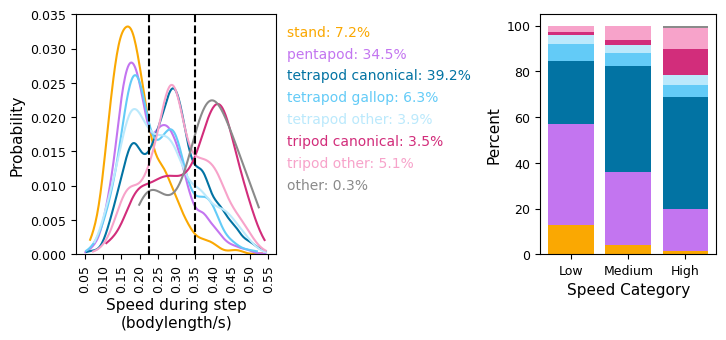

In [30]:
'''
All hexapod gait categories
'''

# partition speeds into three groups: low, medium, high
speed_boundaries = [0,0.225,0.35,1]

# set up categories and values to plot
hex_categories = ['stand','pentapod','tetrapod_canonical','tetrapod_gallop','tetrapod_other',
              'tripod_canonical','tripod_other','other']
# include unclassified?
hex_include_unclassified = False

# set up figure
f = plt.figure(figsize=(8,3))
ax1 = f.add_axes([0.1,0.1,0.25,0.8])
axLeg = f.add_axes([0.33,0.1,0.2,0.8])
ax2 = f.add_axes([0.68,0.1,0.22,0.8])

# get LEFT axis
ax1, hex_category_lists, hex_category_names, hex_color_dict = gaitDensityPlot(ax1, 
                        hex_categories, gaitspeed_df, speed_col, hex_include_unclassified)
ax1.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax1.tick_params(axis='both', which='major', labelsize=tick_fontsize)
ax1.tick_params(axis='x', rotation=90)
ax1.yaxis.label.set_size(axis_fontsize)
ax1.set_xlabel('Speed during step\n(bodylength/s)', fontsize=axis_fontsize)
ax1.set_ylim([0,0.03])

'''
RIGHT = % in each gait in speed categories low, medium, high
'''
# all_speeds = []
# for speed_vals in category_lists:
#     all_speeds.extend(speed_vals)
# plot distribution of different speeds?
# ax2 = sns.histplot(all_speeds, binwidth = 0.01, ax=ax2)

# partition speeds into three groups: low, medium, high
ax2 = speedPartitionPlot(ax2, speed_boundaries, hex_category_lists, 
                         hex_category_names, hex_color_dict)
ax2.xaxis.label.set_text('Speed Category')
ax2.yaxis.label.set_size(axis_fontsize)
ax2.xaxis.label.set_size(axis_fontsize)

# fake legend
legend_maxy = 5
legend_yincrement = 0.5
legend_x = 2
# how many are in each gait category
hex_percents_in_category = [np.round(len(x) * 100 / np.sum([len(x) for x in hex_category_lists]),1) for x in hex_category_lists]
for i, catname in enumerate(hex_category_names):
    axLeg.text(legend_x, legend_maxy-(i*legend_yincrement), 
            catname + ': ' + str(hex_percents_in_category[i]) + '%', 
            color=hex_color_dict[catname.replace(' ','_')])
axLeg.set_axis_off()
axLeg.set_xlim([1.5,4.5])
axLeg.set_ylim([0,5.5])

max_line = 0.035
for i in [1,2]:
    ax1.plot([speed_boundaries[i],speed_boundaries[i]],[0,max_line],'--k')

for ax in [ax1,ax2]:
    ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
    ax.yaxis.label.set_size(axis_fontsize)
    ax.xaxis.label.set_size(axis_fontsize)
ax1.set_ylim([0,max_line])

plt.show()

# Combined figure: speed partitioning

2423 2423


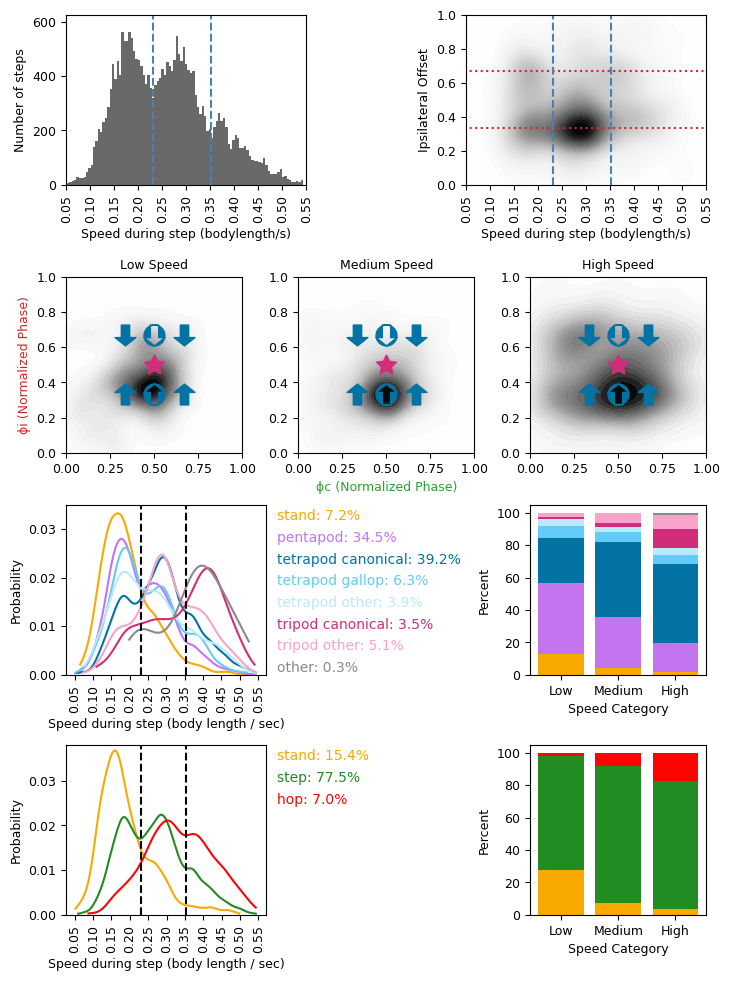

In [31]:
f = plt.figure(figsize=(8,10))
speed_ax = f.add_axes(  [0.1, 0.78,0.3,0.17]) # speed histogram
sp_ipsi_ax = f.add_axes([0.6,0.78,0.3,0.17], sharex=speed_ax) # speed vs. ipsilateral offset greyscale heatmap

low_ax = f.add_axes( [0.1, 0.5,0.22,0.2]) # low speed grayscale heat map
med_ax = f.add_axes( [0.39,0.5,0.22,0.2],sharex=low_ax, sharey=low_ax) # medium speed greyscale heat map
high_ax = f.add_axes([0.68,0.5,0.22,0.2],sharex=low_ax, sharey=low_ax) # high speed greyscale heat map

hex_part_ax = f.add_axes( [0.1, 0.29,0.25,0.17])
hex_leg_ax = f.add_axes(  [0.33,0.29,0.2,0.17])
hex_bar_ax = f.add_axes(  [0.68,0.29,0.22,0.17])

rear_part_ax = f.add_axes( [0.1, 0.05,0.25,0.17])
rear_leg_ax = f.add_axes(  [0.33,0.05,0.2,0.17])
rear_bar_ax = f.add_axes(  [0.68,0.05,0.22,0.17])

# partition speeds into three groups: low, medium, high
speed_boundaries = [0,0.23,0.352,1]

# speed histogram
import matplotlib.ticker as ticker
tick_spacing = 0.05

### SPEED HISTOGRAM
# load the gait_speeds data into a dataframe
# 'cruising' does not matter here because we only measure steps during cruising
gaitspeed_df = pd.read_excel(excel_file, sheet_name='gait_speeds', index_col=None)
speed_col = 'speed (bodylength/s)' # 'speed (bodylength/s)' or 'speed (mm/s)' 

speed_ax.hist(gaitspeed_df[speed_col].values, bins=100, color='dimgrey')
speed_ax.set_ylabel('Number of steps')

### speed vs. ipsilateral offset greyscale heatmaps
ipsi_proportions = []
ipsi_speeds = []
ipsi_offsets = []

for leg in ipsi_offset_legs:
    ipsi_offsets, ipsi_proportions, ipsi_speeds = swingTimingProportions(ipsi_offsets, ipsi_proportions, 
                                                                         ipsi_speeds, step_df, leg, 
                                                                         ipsi_legs[leg])

print(len(ipsi_proportions), len(ipsi_speeds))

sp_ipsi_ax = sns.kdeplot(ax=sp_ipsi_ax, x=ipsi_speeds, y=ipsi_proportions, fill=True, cmap='Greys', thresh=0, levels=50)
sp_ipsi_ax.set_ylabel('Ipsilateral Offset', fontsize=axis_fontsize)
sp_ipsi_ax.plot([0,1],[1/3,1/3],':',color=ipsi_color)
sp_ipsi_ax.plot([0,1],[2/3,2/3],':',color=ipsi_color)
sp_ipsi_ax.set_ylim([0,1])

for ax in [speed_ax,sp_ipsi_ax]:
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
    ax.tick_params(axis='x', rotation=90)
    ax.xaxis.label.set_size(axis_fontsize)
    ax.yaxis.label.set_size(axis_fontsize)
    ax.set_xlabel('Speed during step (bodylength/s)', fontsize=axis_fontsize)
    # ax.xaxis.label.set_text('hihihihi') # cool

for i in [1,2]:
    speed_ax.plot([speed_boundaries[i],speed_boundaries[i]],[0,625],'--',color='steelblue')
    sp_ipsi_ax.plot([speed_boundaries[i],speed_boundaries[i]],[0,1],'--',color='steelblue')

speed_ax.set_ylim([0,625])
speed_ax.set_xlim([0.05,0.55])

### three speeds in the middle   
cmap = 'Greys' # Greys or binary

low_ax = sns.kdeplot(ax=low_ax, x=slow_contra, y=slow_ipsi, fill=True, cmap=cmap, thresh=0, levels=25) 
low_ax.set_title('Low Speed', fontsize=tick_fontsize)

med_ax = sns.kdeplot(ax=med_ax, x=medium_contra, y=medium_ipsi, fill=True, cmap=cmap, thresh=0, levels=25) 
med_ax.set_title('Medium Speed', fontsize=tick_fontsize)

high_ax = sns.kdeplot(ax=high_ax, x=fast_contra, y=fast_ipsi, fill=True, cmap=cmap, thresh=0, levels=25) 
high_ax.set_title('High Speed', fontsize=tick_fontsize)

for ax in [low_ax,med_ax,high_ax]:
    ax=offsetGaitstyleLabels(ax, False)
#     ax.set_xlim([0.05,0.95])
#     ax.set_ylim([0.05,0.95]) 
#     ax.set_xlabel('ϕc (Normalized Phase)', fontsize=tick_fontsize, color=contra_color)
    ax.xaxis.label.set_text('') # cool 
    ax.yaxis.label.set_text('') # cool 
    ax.set_aspect('equal')

low_ax.set_ylabel('ϕi (Normalized Phase)', fontsize=tick_fontsize, color=ipsi_color)
med_ax.set_xlabel('ϕc (Normalized Phase)', fontsize=tick_fontsize, color=contra_color)

### hexapod gait styles in speed partitions
hex_part_ax, hex_category_lists, hex_category_names, hex_color_dict = gaitDensityPlot(hex_part_ax, 
                                                                  hex_categories, 
                                                                  gaitspeed_df, 
                                                                  speed_col, 
                                                                  hex_include_unclassified)

# hex legend
legend_maxy = 5
legend_yincrement = 0.7
legend_x = 2
# how many are in each gait category
hex_percents_in_category = [np.round(len(x) * 100 / np.sum([len(x) for x in hex_category_lists]),1) for x in hex_category_lists]
for i, catname in enumerate(hex_category_names):
    hex_leg_ax.text(legend_x, legend_maxy-(i*legend_yincrement), 
            catname + ': ' + str(hex_percents_in_category[i]) + '%', 
            color=hex_color_dict[catname.replace(' ','_')])
hex_leg_ax.set_axis_off()
hex_leg_ax.set_xlim([1.5,4.5])
hex_leg_ax.set_ylim([0,5.5])

# hex proportions
hex_bar_ax = speedPartitionPlot(hex_bar_ax, speed_boundaries, hex_category_lists, 
                         hex_category_names, hex_color_dict)


### rear gait styles in speed partitions
rear_part_ax, rear_category_lists, rear_category_names, rear_color_dict = gaitDensityPlot(rear_part_ax, 
                                                                  rear_categories, 
                                                                  gaitspeed_df, 
                                                                  speed_col, 
                                                                  rear_include_unclassified)

# rear legend
legend_maxy = 5
legend_yincrement = 0.7
legend_x = 2
# how many are in each gait category
rear_percents_in_category = [np.round(len(x) * 100 / np.sum([len(x) for x in rear_category_lists]),1) for x in rear_category_lists]
for i, catname in enumerate(rear_category_names):
    rear_leg_ax.text(legend_x, legend_maxy-(i*legend_yincrement), 
            catname + ': ' + str(rear_percents_in_category[i]) + '%', 
            color=rear_color_dict[catname.replace(' ','_')])
rear_leg_ax.set_axis_off()
rear_leg_ax.set_xlim([1.5,4.5])
rear_leg_ax.set_ylim([0,5.5])

# rear proportions
rear_bar_ax = speedPartitionPlot(rear_bar_ax, speed_boundaries, rear_category_lists, 
                         rear_category_names, rear_color_dict)

max_lines = [0.035, 0.038]
for i, ax in enumerate([hex_part_ax, rear_part_ax]):
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
    ax.tick_params(axis='x', rotation=90)
    ax.yaxis.label.set_size(axis_fontsize)
    ax.set_xlabel('Speed during step (body length / sec)', fontsize=axis_fontsize)
    max_line = max_lines[i]
    ax.plot([speed_boundaries[1],speed_boundaries[1]],[0,max_line],'--k')
    ax.plot([speed_boundaries[2],speed_boundaries[2]],[0,max_line],'--k')
    ax.set_ylim([0,max_line]) 

for ax in [hex_bar_ax, rear_bar_ax]:
    ax.xaxis.label.set_text('Speed Category')
    ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
    ax.yaxis.label.set_size(tick_fontsize)
    ax.xaxis.label.set_size(tick_fontsize)
    
###
for ax in [speed_ax, sp_ipsi_ax, low_ax, med_ax, high_ax, hex_part_ax, rear_part_ax]:
    ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
    ax.xaxis.label.set_size(tick_fontsize)
    ax.yaxis.label.set_size(tick_fontsize)

plt.show()

2408 2408
266 266
Tetrapod ρ = -0.007 , p =  0.733
Tripod   ρ = 0.128 , p =  0.037


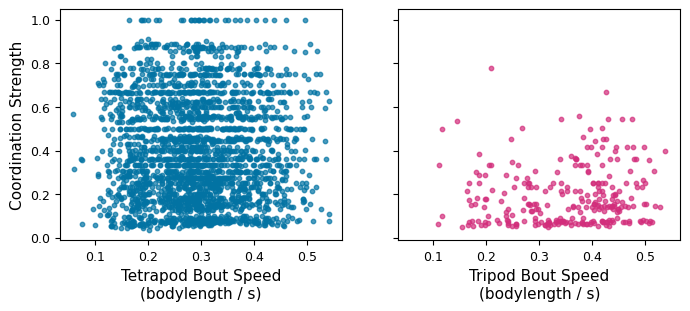

In [32]:
# WORKING
# if more ϕc at 1/3 and 2/3 at higher speeds, expect higher tetrapod coordination scores?
# need to confirm (again) that I am calculating these correctly
#    double check data ... looks good
#    check simulated data ... ok but problems when frame times are not the same as simulated step times

# check T.C.S in low / medium / high speeds

# Scatter of ALL bouts
def nonan(x):
    return x[~np.isnan(x)]

gait_speeds_df = pd.read_excel(excel_file, sheet_name='gait_speeds', index_col=None)
gait_speeds_df.head(3)
tetrapod_coordination = gait_speeds_df.tetrapod_coordination.values
tetrapod_speed = gait_speeds_df.tetrapod_speed.values
tripod_coordination = gait_speeds_df.tripod_coordination.values
tripod_speed = gait_speeds_df.tripod_speed.values

tetrapod_coordination = nonan(tetrapod_coordination)
tetrapod_speed = nonan(tetrapod_speed)
tripod_coordination = nonan(tripod_coordination)
tripod_speed = nonan(tripod_speed)

print(len(tetrapod_coordination), len(tetrapod_speed))
print(len(tripod_coordination), len(tripod_speed))

f,(a1,a2) = plt.subplots(1,2,figsize=(8,3), sharey=True, sharex=True)
a1.scatter(tetrapod_speed, tetrapod_coordination, s=marker_size, c=tetra_color, alpha=marker_alpha, label='tetrapod')
a2.scatter(tripod_speed, tripod_coordination, s=marker_size, c=tripod_color, alpha=marker_alpha, label='tripod')
a1.set_ylabel('Coordination Strength', fontsize=axis_fontsize)
a1.set_xlabel('Tetrapod Bout Speed\n(bodylength / s)', fontsize=axis_fontsize)
a2.set_xlabel('Tripod Bout Speed\n(bodylength / s)', fontsize=axis_fontsize)
a1.tick_params(axis='both', which='major', labelsize=tick_fontsize) 
a2.tick_params(axis='both', which='major', labelsize=tick_fontsize) 
spearmanr_tet = stats.spearmanr(tetrapod_speed,tetrapod_coordination)
spearmanr_tri = stats.spearmanr(tripod_speed,tripod_coordination)
print('Tetrapod ρ =', round(spearmanr_tet.statistic,3), ', p = ', round(spearmanr_tet.pvalue,3))
print('Tripod   ρ =', round(spearmanr_tri.statistic,3), ', p = ', round(spearmanr_tri.pvalue,3))
plt.show()

In [ ]:
# partition these into low / medium / high speeds . . . 

# Extras ... not much important below

## Partitioning contralateral offsets into 1/3 and 2/3
### which is not really valid because it depends on L vs. R

In [ ]:
'''
THIS IS NOT SO USEFUL, AS THE CONTRALATERAL OFFSETS DO NOT REALLY HAVE TWO 'MODES'

Separate the contralateral offsets into the two 'modes' (.28-.38; .61-.71) 
and plot (scatter? kde?) vs. opposite offsets for those steps. 
Expect 0.3/0.3 0.6/0.6 maybe? Or four blobs?
    (from above - I will get four blobs, two each)
'''
low_boundaries = [0.28, 0.38]
within_low = np.where((cont_phase>=low_boundaries[0]) & (cont_phase<=low_boundaries[1]))
ipsi_low = ipsi_phase[within_low]
cont_low = cont_phase[within_low]
print(len(ipsi_low),len(cont_low))

high_boundaries = [0.61, 0.71]
within_high = np.where((cont_phase>=high_boundaries[0]) & (cont_phase<=high_boundaries[1]))
ipsi_high = ipsi_phase[within_high]
cont_high = cont_phase[within_high]
print(len(ipsi_high),len(cont_high))

fig,[ax1,ax2] = plt.subplots(1,2,figsize=(10,3.8))
# ax1 = sns.kdeplot(ax=ax1, x=cont_low, y=ipsi_low, fill=True, cmap='viridis', thresh=0, levels=50)
# ax2 = sns.kdeplot(ax=ax2, x=cont_high, y=ipsi_high, fill=True, cmap='viridis', thresh=0, levels=50)

# ax1.hist(ipsi_low, bins=50)
# ax2.hist(ipsi_high, bins=50)

ax1 = sns.histplot(ipsi_low, stat='density', binwidth=0.005, ax=ax1, kde=True,
                  element='step', fill=False, visible=False, color='tab:green')
ax2 = sns.histplot(ipsi_high, stat='density', binwidth=0.005, ax=ax2, kde=True,
                  element='step', fill=False, visible=False, color='tab:blue')

ax1.set_xlabel('ϕi (Normalized Phase)', fontsize=14)
ax1.tick_params(axis='both', which='major', labelsize=10)
ax1.set_title('Low ϕc',fontsize=14)
ax1.plot([0.33,0.33],[0,3],'--k')
ax1.plot([0.66,0.66],[0,3],'--k')
ax1.set_ylim([0,3])

ax2.set_xlabel('ϕi (Normalized Phase)', fontsize=14)
ax2.tick_params(axis='both', which='major', labelsize=10)
ax2.set_title('High ϕc',fontsize=14)
ax2.plot([0.33,0.33],[0,3],'--k')
ax2.plot([0.66,0.66],[0,3],'--k')
ax2.set_ylim([0,3])

# ax1.set_aspect('equal')
plt.show()

## Size vs. Speed
* area vs. speed (mm/s and bodylength/s)
* length vs. speed
* width vs. speed
* width/length ('chubbiness') vs. speed

In [68]:
xl = pd.ExcelFile(excel_file)
print(xl.sheet_names)

['path_summaries', 'step_timing', 'step_summaries', 'gait_summaries', 'gait_speeds']


In [69]:
path_summaries_df = xl.parse('path_summaries') # has size and speed info
print(path_summaries_df.columns)
path_summaries_df.head(3)

Index(['Identifier', 'treatment', 'individual', 'date',
       'Scale (pixels in 1mm)', 'Body Size (mm^2)', 'Body Length (mm)',
       'Body Width (mm)', 'Body Width/Length Ratio', 'Duration analyzed (sec)',
       'Distance traveled (mm)', 'Speed (mm/sec)',
       'Speed (body lengths / sec)', 'Percentage of time cruising',
       'Speed (mm/sec cruising)', 'Speed (body lengths / sec cruising)',
       'Total bearing change (deg)', 'Bearing change (deg) / sec',
       'Bearing change (deg) / sec cruising', 'Number of stops', 'Stops / sec',
       'Number of turns', 'Turns / sec'],
      dtype='object')


,Identifier,treatment,individual,date,Scale (pixels in 1mm),Body Size (mm^2),Body Length (mm),Body Width (mm),Body Width/Length Ratio,Duration analyzed (sec),...,Percentage of time cruising,Speed (mm/sec cruising),Speed (body lengths / sec cruising),Total bearing change (deg),Bearing change (deg) / sec,Bearing change (deg) / sec cruising,Number of stops,Stops / sec,Number of turns,Turns / sec
0,iw_11dec_tardigrade01_exemplaris,exemplaris,tardigrade01,11dec,956.03,0.017560,0.265809,0.089788,0.337792,112.6362,...,93.058918,0.047823,0.179915,2237.019467,19.860573,16.877872,10,0.088781,5,0.044391
1,iw_11dec_tardigrade02_exemplaris,exemplaris,tardigrade02,11dec,956.03,0.013457,0.239711,0.073674,0.307344,110.1818,...,84.213421,0.053403,0.222783,1648.051800,14.957568,16.375356,11,0.099835,1,0.009076
2,iw_11dec_tardigrade03_exemplaris,exemplaris,tardigrade03,11dec,956.03,0.017790,0.271046,0.089991,0.332014,106.0909,...,59.297344,0.040661,0.150015,2372.522533,22.363111,22.966600,35,0.329906,15,0.141388


Tardigrade Area (mm^2) vs. Speed (mm/sec) ρ = 0.27 p = 0.06
Tardigrade Area (mm^2) vs. Speed (bodylength/sec) ρ = -0.05 p = 0.73
Tardigrade Area (mm^2) vs. Cruising Speed (mm/sec) ρ = 0.35 p = 0.01
Tardigrade Area (mm^2) vs. Cruising Speed (bodylength/sec) ρ = -0.02 p = 0.91


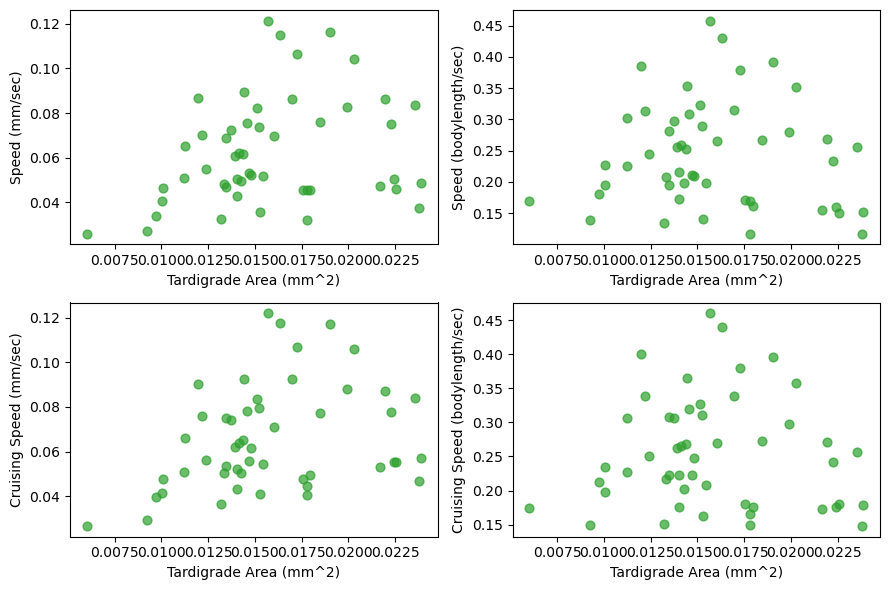

In [70]:
# Area vs. Speed
fig, axes = plt.subplots(2,2, figsize=(9,6))
[[a1,a2],[a3,a4]] = axes

areas = path_summaries_df['Body Size (mm^2)'].values
speed_mm = path_summaries_df['Speed (mm/sec)'].values
speed_bodylength = path_summaries_df['Speed (body lengths / sec)'].values
cruising_speed_mm = path_summaries_df['Speed (mm/sec cruising)'].values
cruising_speed_bodylength = path_summaries_df['Speed (body lengths / sec cruising)'].values

def scat(ax, x, y, xlab, ylab, col = 'tab:green'):
    ax.scatter(x,y,s=40,alpha=0.7,color=col)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    r,p = stats.spearmanr(x,y)
    print(xlab + ' vs. ' + ylab + ' ρ =', np.round(r,2), 'p =', np.round(p,2))
    return ax

a1 = scat(a1, areas, speed_mm, 'Tardigrade Area (mm^2)', 'Speed (mm/sec)')
a2 = scat(a2, areas, speed_bodylength, 'Tardigrade Area (mm^2)', 'Speed (bodylength/sec)')
a3 = scat(a3, areas, cruising_speed_mm, 'Tardigrade Area (mm^2)', 'Cruising Speed (mm/sec)')
a4 = scat(a4, areas, cruising_speed_bodylength, 'Tardigrade Area (mm^2)', 'Cruising Speed (bodylength/sec)')

plt.tight_layout()
plt.show()

Body Length (mm) vs. Speed (mm/sec) ρ = 0.32 p = 0.02
Body Length (mm) vs. Speed (bodylength/sec) ρ = -0.0 p = 1.0
Body Length (mm) vs. Cruising Speed (mm/sec) ρ = 0.39 p = 0.0
Body Length (mm) vs. Cruising Speed (bodylength/sec) ρ = 0.03 p = 0.86


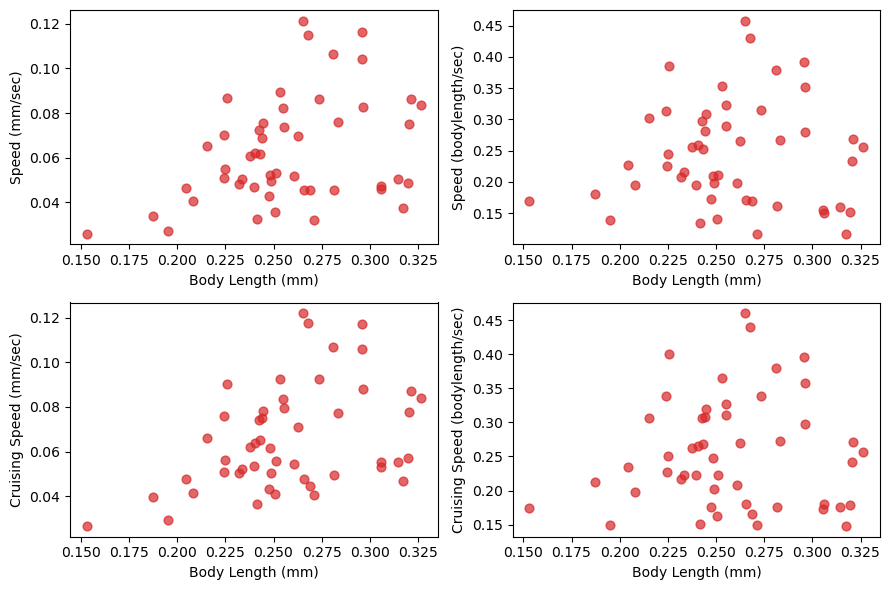

In [71]:
# Length vs. Speed
fig, axes = plt.subplots(2,2, figsize=(9,6))
[[a1,a2],[a3,a4]] = axes

lengths = path_summaries_df['Body Length (mm)'].values
speed_mm = path_summaries_df['Speed (mm/sec)'].values
speed_bodylength = path_summaries_df['Speed (body lengths / sec)'].values
cruising_speed_mm = path_summaries_df['Speed (mm/sec cruising)'].values
cruising_speed_bodylength = path_summaries_df['Speed (body lengths / sec cruising)'].values

col = 'tab:red'
a1 = scat(a1, lengths, speed_mm, 'Body Length (mm)', 'Speed (mm/sec)', col)
a2 = scat(a2, lengths, speed_bodylength, 'Body Length (mm)', 'Speed (bodylength/sec)', col)
a3 = scat(a3, lengths, cruising_speed_mm, 'Body Length (mm)', 'Cruising Speed (mm/sec)', col)
a4 = scat(a4, lengths, cruising_speed_bodylength, 'Body Length (mm)', 'Cruising Speed (bodylength/sec)', col)

plt.tight_layout()
plt.show()

Body Width (mm) vs. Speed (mm/sec) ρ = 0.12 p = 0.41
Body Width (mm) vs. Speed (bodylength/sec) ρ = -0.2 p = 0.16
Body Width (mm) vs. Cruising Speed (mm/sec) ρ = 0.19 p = 0.18
Body Width (mm) vs. Cruising Speed (bodylength/sec) ρ = -0.16 p = 0.25


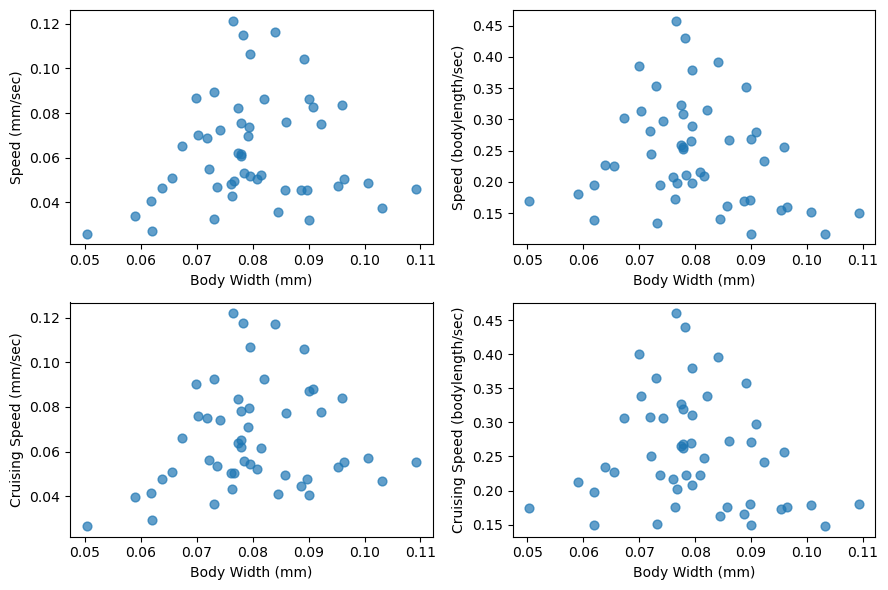

In [72]:
# Width vs. Speed
fig, axes = plt.subplots(2,2, figsize=(9,6))
[[a1,a2],[a3,a4]] = axes

widths = path_summaries_df['Body Width (mm)'].values
speed_mm = path_summaries_df['Speed (mm/sec)'].values
speed_bodylength = path_summaries_df['Speed (body lengths / sec)'].values
cruising_speed_mm = path_summaries_df['Speed (mm/sec cruising)'].values
cruising_speed_bodylength = path_summaries_df['Speed (body lengths / sec cruising)'].values

col = 'tab:blue'
a1 = scat(a1, widths, speed_mm, 'Body Width (mm)', 'Speed (mm/sec)', col)
a2 = scat(a2, widths, speed_bodylength, 'Body Width (mm)', 'Speed (bodylength/sec)', col)
a3 = scat(a3, widths, cruising_speed_mm, 'Body Width (mm)', 'Cruising Speed (mm/sec)', col)
a4 = scat(a4, widths, cruising_speed_bodylength, 'Body Width (mm)', 'Cruising Speed (bodylength/sec)', col)

plt.tight_layout()
plt.show()

Width:Length Ratio vs. Speed (mm/sec) ρ = -0.62 p = 0.0
Width:Length Ratio vs. Speed (bodylength/sec) ρ = -0.54 p = 0.0
Width:Length Ratio vs. Cruising Speed (mm/sec) ρ = -0.59 p = 0.0
Width:Length Ratio vs. Cruising Speed (bodylength/sec) ρ = -0.52 p = 0.0


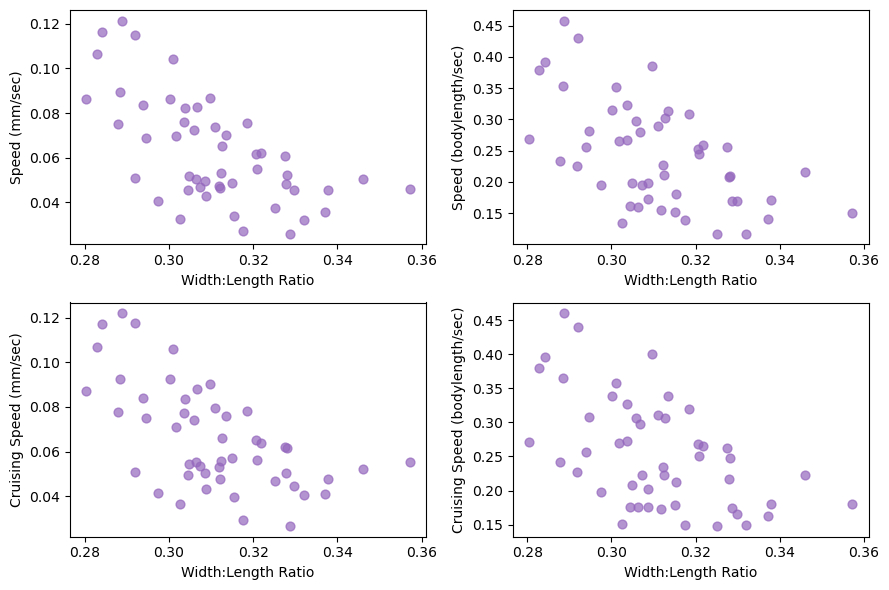

In [73]:
# Width/Length Ratio vs. Speed
fig, axes = plt.subplots(2,2, figsize=(9,6))
[[a1,a2],[a3,a4]] = axes

ratios = path_summaries_df['Body Width/Length Ratio'].values
speed_mm = path_summaries_df['Speed (mm/sec)'].values
speed_bodylength = path_summaries_df['Speed (body lengths / sec)'].values
cruising_speed_mm = path_summaries_df['Speed (mm/sec cruising)'].values
cruising_speed_bodylength = path_summaries_df['Speed (body lengths / sec cruising)'].values

col = 'tab:purple'
a1 = scat(a1, ratios, speed_mm, 'Width:Length Ratio', 'Speed (mm/sec)', col)
a2 = scat(a2, ratios, speed_bodylength, 'Width:Length Ratio', 'Speed (bodylength/sec)', col)
a3 = scat(a3, ratios, cruising_speed_mm, 'Width:Length Ratio', 'Cruising Speed (mm/sec)', col)
a4 = scat(a4, ratios, cruising_speed_bodylength, 'Width:Length Ratio', 'Cruising Speed (bodylength/sec)', col)

plt.tight_layout()
plt.show()

# Speed vs. offsets

In [74]:
step_summaries_df = xl.parse('step_summaries') # has size and speed info
print(step_summaries_df.columns)
step_summaries_df.head(3)

Index(['Identifier', 'treatment', 'individual',
       'Stance duration (lateral legs)', 'Swing duration (lateral legs)',
       'Gait cycle (lateral legs)', 'Duty factor (lateral legs)',
       'mm per step (lateral legs)', 'bodylength per step (lateral legs)',
       'Stance duration (rear legs)', 'Swing duration (rear legs)',
       'Gait cycle (rear legs)', 'Duty factor (rear legs)',
       'mm per step (rear legs)', 'bodylength per step (rear legs)',
       'Metachronal lag (lateral legs)',
       'Metachronal lag (normalized, lateral legs)',
       'Metachronal lag Left-Right Ratio',
       'Anterior swing offsets (lateral legs)',
       'Anterior swing offsets (normalized, lateral legs)',
       'Opposite swing offsets (lateral legs)',
       'Opposite swing offsets (normalized, lateral legs)',
       'Opposite swing offsets (rear legs)',
       'Opposite swing offsets (normalized, rear legs)'],
      dtype='object')


,Identifier,treatment,individual,Stance duration (lateral legs),Swing duration (lateral legs),Gait cycle (lateral legs),Duty factor (lateral legs),mm per step (lateral legs),bodylength per step (lateral legs),Stance duration (rear legs),...,bodylength per step (rear legs),Metachronal lag (lateral legs),"Metachronal lag (normalized, lateral legs)",Metachronal lag Left-Right Ratio,Anterior swing offsets (lateral legs),"Anterior swing offsets (normalized, lateral legs)",Opposite swing offsets (lateral legs),"Opposite swing offsets (normalized, lateral legs)",Opposite swing offsets (rear legs),"Opposite swing offsets (normalized, rear legs)"
0,iw_11dec_tardigrade01_exemplaris,exemplaris,tardigrade01,1.038565,0.291355,1.329919,0.775582,0.045352,0.170799,0.531367,...,0.086696,1.638500,1.229424,0.345009,0.843844,0.620441,0.653679,0.480877,0.477846,0.495000
1,iw_11dec_tardigrade02_exemplaris,exemplaris,tardigrade02,0.630924,0.259400,0.890324,0.702079,0.040009,0.167006,0.445486,...,0.115837,0.799484,0.896598,0.301717,0.397933,0.438180,0.455132,0.512152,0.410062,0.519129
2,iw_11dec_tardigrade03_exemplaris,exemplaris,tardigrade03,1.185420,0.313980,1.499400,0.784704,0.049132,0.181463,0.717000,...,0.108222,1.594462,1.064675,0.323230,0.819346,0.540057,0.739917,0.485374,0.545450,0.504456


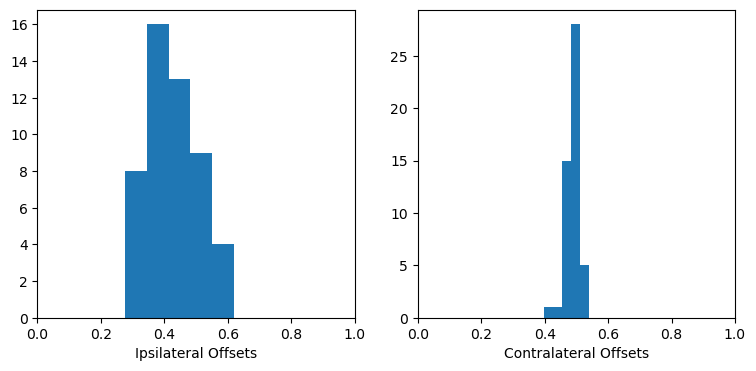

In [75]:
fig, [a1,a2] = plt.subplots(1,2, figsize=(9,4))
contra_offsets = step_summaries_df['Opposite swing offsets (normalized, lateral legs)'].values
ipsi_offsets = step_summaries_df['Anterior swing offsets (normalized, lateral legs)'].values
a1.hist(ipsi_offsets, bins=5)
a1.set_xlabel('Ipsilateral Offsets')
a1.set_xlim([0,1])

a2.hist(contra_offsets, bins=5)
a2.set_xlabel('Contralateral Offsets')
a2.set_xlim([0,1])

plt.show()

Ipsilateral Offset vs. Speed (mm/s cruising) ρ = -0.16 p = 0.27
Contralateral Offset vs. Speed (mm/s cruising) ρ = 0.11 p = 0.46
Ipsilateral Offset vs. Speed (bodylength/s cruising) ρ = -0.25 p = 0.07
Contralateral Offset vs. Speed (bodylength/s cruising) ρ = 0.04 p = 0.77


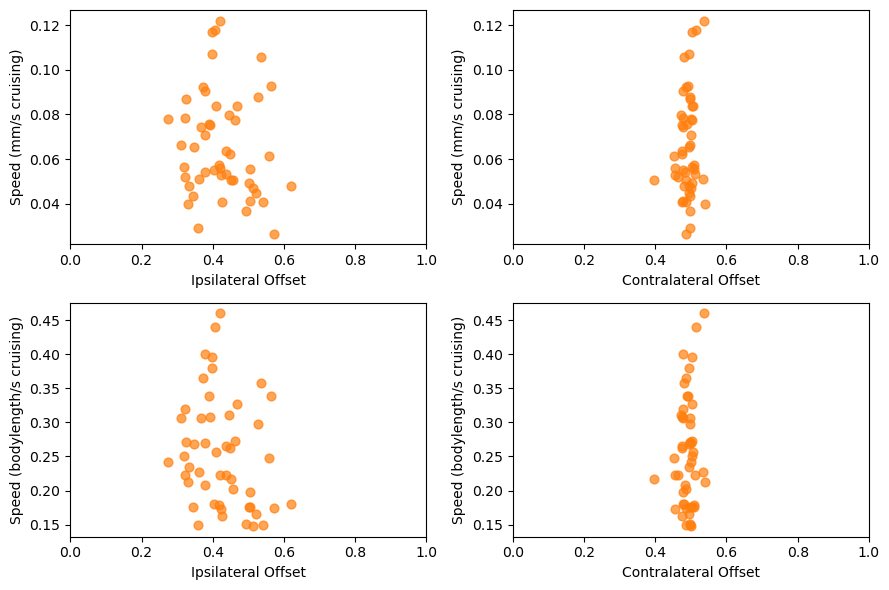

In [76]:
# Cruising Speed vs. Anterior and Opposite Offsets
fig, axes = plt.subplots(2,2, figsize=(9,6))
[[a1,a2],[a3,a4]] = axes

contra_offsets = step_summaries_df['Opposite swing offsets (normalized, lateral legs)'].values
ipsi_offsets = step_summaries_df['Anterior swing offsets (normalized, lateral legs)'].values
cruising_speed_mm = path_summaries_df['Speed (mm/sec cruising)'].values
cruising_speed_bodylength = path_summaries_df['Speed (body lengths / sec cruising)'].values

col = 'tab:orange'
a1 = scat(a1, ipsi_offsets, cruising_speed_mm, 
          'Ipsilateral Offset', 'Speed (mm/s cruising)', col)
a2 = scat(a2, contra_offsets, cruising_speed_mm, 
          'Contralateral Offset', 'Speed (mm/s cruising)', col)
a3 = scat(a3, ipsi_offsets, cruising_speed_bodylength, 
          'Ipsilateral Offset', 'Speed (bodylength/s cruising)', col)
a4 = scat(a4, contra_offsets, cruising_speed_bodylength, 
          'Contralateral Offset', 'Speed (bodylength/s cruising)', col)

a1.set_xlim([0,1])
a2.set_xlim([0,1])
a3.set_xlim([0,1])
a4.set_xlim([0,1])
plt.tight_layout()
plt.show()

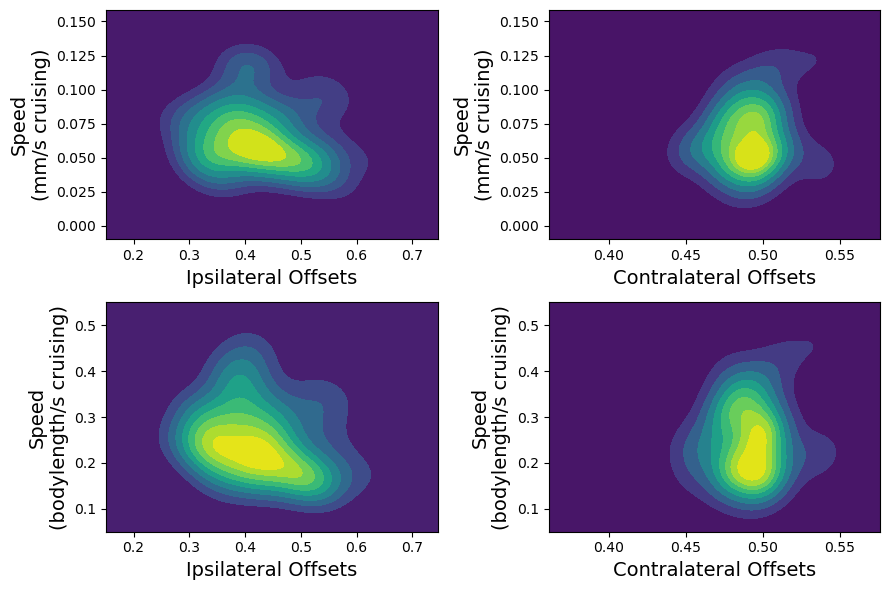

In [77]:
# Cruising Speed vs. Anterior and Opposite Offsets
fig, axes = plt.subplots(2,2, figsize=(9,6))
[[a1,a2],[a3,a4]] = axes

contra_offsets = step_summaries_df['Opposite swing offsets (normalized, lateral legs)'].values
ipsi_offsets = step_summaries_df['Anterior swing offsets (normalized, lateral legs)'].values
cruising_speed_mm = path_summaries_df['Speed (mm/sec cruising)'].values
cruising_speed_bodylength = path_summaries_df['Speed (body lengths / sec cruising)'].values


a1 = sns.kdeplot(ax=a1, x=ipsi_offsets, y=cruising_speed_mm, fill=True, cmap='viridis', thresh=0, levels=10)
a1.set_xlabel('Ipsilateral Offsets', fontsize=14)
a1.set_ylabel('Speed\n(mm/s cruising)', fontsize=14)
a2 = sns.kdeplot(ax=a2, x=contra_offsets, y=cruising_speed_mm, fill=True, cmap='viridis', thresh=0, levels=10)
a2.set_xlabel('Contralateral Offsets', fontsize=14)
a2.set_ylabel('Speed\n(mm/s cruising)', fontsize=14)
a3 = sns.kdeplot(ax=a3, x=ipsi_offsets, y=cruising_speed_bodylength, fill=True, cmap='viridis', thresh=0, levels=10)
a3.set_xlabel('Ipsilateral Offsets', fontsize=14)
a3.set_ylabel('Speed\n(bodylength/s cruising)', fontsize=14)
a4 = sns.kdeplot(ax=a4, x=contra_offsets, y=cruising_speed_bodylength, fill=True, cmap='viridis', thresh=0, levels=10)
a4.set_xlabel('Contralateral Offsets', fontsize=14)
a4.set_ylabel('Speed\n(bodylength/s cruising)', fontsize=14)

a3.set_ylim([0.05,0.55])
a4.set_ylim([0.05,0.55])
plt.tight_layout()
plt.show()